# Collecting Brazil's 2022 presidential election polls data
> A tutorial on how to collect, filter and prepare for analysis Brazil's 2022 presidential election polls data.

- toc: true 
- badges: true
- comments: true
- categories: [data-science]
- hide: false
- search_exclude: false
- image: images/chart-preview.png

## Context

This year [more than 146 million fellow Brazilian](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo) are going to choose our new President...

## Data sources

### Pool data
- [Poder360 polls database](https://www.poder360.com.br/banco-de-dados/)
### Voters statistics

- [TSE: Voters statistics by Region](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/consulta-quantitativo)
- [TSE: Voters statistics by sex and age](https://www.tse.jus.br/eleitor/estatisticas-de-eleitorado/estatistica-do-eleitorado-por-sexo-e-faixa-etaria)

### Dashboard
- [App](https://chance-lula-ganhar-1o-turno.github.io/)
- [Repositório: Chance de Lula ganhar no primeiro turno](https://github.com/chance-lula-ganhar-1o-turno)
  

## Analysis

### Importing libraries

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
from pathlib import Path
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Load and transform data

In [2]:
#noshow 
columns_to_use = ["pesquisa_id", "cenario_id", "turno", "partido",
                  "candidato", "cenario_descricao", "instituto",
                  "percentual", "data_pesquisa", "qtd_entrevistas",
                  "qtd_mencoes","grupo"]

HDI = [0.025, 0.5, 0.975] # quantiles

In [3]:
def enrich_and_filter(df: pd.DataFrame) ->pd.DataFrame:
    df['qtd_mencoes'] = df.percentual * df.qtd_entrevistas / 100.0
    df['grupo'] = 'OUTROS'
    df.loc[(df.partido == 'PT'), 'grupo'] = 'LULA'
    df.loc[(df.partido.isna()), 'grupo'] = 'NULO'

    return df[columns_to_use]

In [4]:
def get_most_recent_file() -> Path:
    data_dir = Path('../assets/data/elections2022/')
    return sorted(data_dir.glob('2022*.csv'))[-1]
print(get_most_recent_file())

../assets/data/elections2022/20220201.csv


In [5]:
def get_most_recent_df() -> pd.DataFrame:
    return enrich_and_filter(pd.read_csv(get_most_recent_file(),
                                         sep=',',
                                         parse_dates=True,
                                         dayfirst=True)
                             )


In [6]:
raw_df = get_most_recent_df()
raw_df.head()

,pesquisa_id,cenario_id,turno,partido,candidato,cenario_descricao,instituto,percentual,data_pesquisa,qtd_entrevistas,qtd_mencoes,grupo
0,9750,24567,1,NaN,não sabe / não respondeu,cenário 1 - estimulado - 1º turno,Vox Populi,12.0,2021-11-04,2000,240.0,NULO
1,9750,24567,1,NaN,branco / nulo / nenhum,cenário 1 - estimulado - 1º turno,Vox Populi,10.0,2021-11-04,2000,200.0,NULO
2,9750,24567,1,PSD,Rodrigo Pacheco,cenário 1 - estimulado - 1º turno,Vox Populi,0.0,2021-11-04,2000,0.0,OUTROS
3,9750,24567,1,PT,Lula,cenário 1 - estimulado - 1º turno,Vox Populi,44.0,2021-11-04,2000,880.0,LULA
4,9750,24567,1,sem partido,Bolsonaro,cenário 1 - estimulado - 1º turno,Vox Populi,21.0,2021-11-04,2000,420.0,OUTROS


In [7]:
def prepare_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    table_df = raw_df.pivot_table(values=['qtd_mencoes'],
                        index=['data_pesquisa', 'instituto'],
                        columns=['grupo'],
                        aggfunc=np.sum)
    table_df2 = table_df
    table2 = table_df.reset_index(col_level=1).copy()
    table2.columns = [a[1] for a in table2.columns.to_flat_index()]
    table2["TOTAL"] = table2['LULA'] + table2['NULO'] + table2['OUTROS']
    table2["mes"] = pd.to_datetime(table2['data_pesquisa']).dt.strftime('%Y_%m')
    # print(table2)
    # table3 = table2.groupby('data_pesquisa').agg({'LULA':'sum', 'NULO':'sum', 'OUTROS':'sum', 'TOTAL':'sum', 'mes':'first', 'instituto': 'first'})
    # table3 = table3.reset_index(col_level=1).copy()
    # print(table3.columns)
    # table3.columns = [a for a in table3.columns.to_flat_index()]
    
    return table2

In [8]:
df = prepare_df(raw_df)
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [9]:
def simulate_prob_freq(concentration: np.array, iters=10_000, N=100_000) -> float:
    priors = stats.dirichlet.rvs(concentration, iters)
    cnt = 0
    for i in range(iters):
        votes = stats.multinomial(n=100_000, p = priors[i]).rvs()[0]
        if votes[0] > votes[2]:
            cnt += 1
    return cnt/iters * 100
# simulate_prob_freq(np.array([723, 186, 780]))
#stats.multinomial(n=100_000, p = np.array([0.45, 0.11, 0.44])).rvs()

In [11]:
def run_prob_weekly(simulate_prob):
    prior = np.array([420,130,450])
    posterior = np.array([0,0,0])
    for obj in df.itertuples():
        like = np.array([obj.LULA, obj.NULO, obj.OUTROS])
        posterior = prior * 0.7 + like * 0.3
        print(obj.data_pesquisa, posterior/posterior.sum(), simulate_prob(posterior))
        prior = posterior

run_prob_weekly(simulate_prob_freq)

2021-11-04 [0.43122102 0.17233385 0.39644513] 91.97
2021-11-06 [0.45102118 0.15920902 0.38976979] 99.58
2021-11-19 [0.41407311 0.1500793  0.43584758] 17.61
2021-11-20 [0.39914407 0.12329248 0.47756345] 0.01
2021-11-24 [0.37827834 0.11116349 0.51055818] 0.0
2021-11-29 [0.40252051 0.07256674 0.52491276] 0.0
2021-12-05 [0.41653328 0.08413037 0.49933635] 0.0
2021-12-09 [0.40861154 0.09193913 0.49944932] 0.0
2021-12-11 [0.4142076  0.10956301 0.4762294 ] 0.16999999999999998
2021-12-13 [0.40393608 0.10239696 0.49366696] 0.01
2021-12-13 [0.42632766 0.11346649 0.46020585] 5.390000000000001
2021-12-16 [0.44967803 0.10760784 0.44271413] 63.239999999999995
2021-12-16 [0.44762626 0.10924581 0.44312793] 59.12
2021-12-21 [0.42939263 0.10953455 0.46107282] 5.11
2022-01-09 [0.43723533 0.11293436 0.44983031] 27.52
2022-01-12 [0.4362757  0.11531045 0.44841384] 28.57
2022-01-13 [0.43065426 0.11424395 0.45510179] 13.52
2022-01-18 [0.42795808 0.11717407 0.45486785] 9.92
2022-01-21 [0.41121419 0.11430964 0.4

In [12]:
mes = df.groupby("mes").sum().reset_index()
mes

,mes,LULA,NULO,OUTROS,TOTAL
0,2021_11,6048.848,1507.332,7382.820,14939.0
1,2021_12,7356.516,1973.626,7586.858,16917.0
2,2022_01,4833.000,1369.000,5249.000,11451.0
3,2022_02,1230.000,240.000,1530.000,3000.0


3.0
[1. 1. 1.]
[1. 1. 1.]


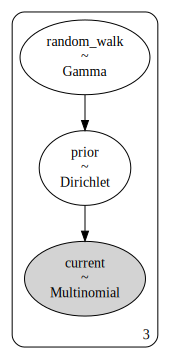

In [12]:
def build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0) -> pm.Model:
    N = observed.sum() if not np.all(np.isnan(observed)) else 1_000
    print(N)
    print(prior)
    print(observed)
    with pm.Model() as dirichlet_model:
        rw = pm.Gamma("random_walk",
                      alpha=(rw_alpha_mult * prior),
                      beta=(rw_beta_mult * np.ones(3)), shape=(3,)
                      )
        
        previous_month_prior = pm.Dirichlet(
            "prior", a=rw, shape=(3,),
        )

        pm.Multinomial(
            "current", n=N, p=(previous_month_prior), observed=observed, shape=(3,)
        )
    
    return dirichlet_model
model = build_model(np.ones(3), np.ones(3))
pm.model_to_graphviz(model)

In [13]:

def sampling(model: pm.Model, samples=2000, chains=2):
    with model:
        dirichlet_trace = pm.sample(samples, tune=2000, chains=chains, return_inferencedata=True, progressbar=False)
        ppc = pm.fast_sample_posterior_predictive(dirichlet_trace, 5000)
    return dirichlet_trace , ppc

def calc_prob_lula_win(model, trace, niter=30, ppc=None):
    simul = []
    if ppc:
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    for _ in tqdm(range(niter)):
        with model:
            ppc = pm.fast_sample_posterior_predictive(trace, 10000)
        lula = ppc['current'][:, 0]
        others = ppc['current'][:, 2]
        simul.append((lula > others).mean() * 100.0)
    simul = np.array(simul)
    return np.quantile(simul, q=HDI)

## MONTHLY

In [14]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()
for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    rw_alpha_mult=1.0; rw_beta_mult=0.5
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=rw_alpha_mult, rw_beta_mult=rw_beta_mult)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model_m, trace_m, 50, ppc=ppc_m)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048 1507 7382]
14937
[420. 130. 450.]
[6048 1507 7382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_11, updaed_prior=[3126.17044929  785.67050576 3793.09404555],  qs=['0.0%', '0.0%', '0.0%'] <<<
lula= [0.39452367 0.4057709  0.41648256]
nulo= [0.09519984 0.10196157 0.10892415]
demais= [0.48122113 0.49226752 0.50304613]
>>> observed = [7356 1973 7586]
16915
[3126.17044929  785.67050576 3793.09404555]
[7356 1973 7586]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_12, updaed_prior=[4103.45211594 1086.7521576  4397.29921018],  qs=['0.03%', '0.06999999999999999%', '0.12%'] <<<
lula= [0.41832693 0.42802247 0.43783624]
nulo= [0.10700562 0.11333136 0.11977535]
demais= [0.44871416 0.45864617 0.46857819]
>>> observed = [4833 1369 5249]
11451
[4103.45211594 1086.7521576  4397.29921018]
[4833 1369 5249]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_01, updaed_prior=[2905.18899189  803.62944103 3139.69071637],  qs=['0.0625%', '0.11%', '0.18%'] <<<
lula= [0.41288752 0.42424242 0.43594446]
nulo= [0.10977207 0.117326   0.12487992]
demais= [0.44686054 0.45847524 0.47017728]
>>> observed = [1230  240 1530]
3000
[2905.18899189  803.62944103 3139.69071637]
[1230  240 1530]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_02, updaed_prior=[ 902.64779555  220.82638308 1032.60496388],  qs=['0.075%', '0.16%', '0.22749999999999998%'] <<<
lula= [0.39833333 0.41866667 0.43934167]
nulo= [0.08966667 0.10233333 0.11533333]
demais= [0.45766667 0.47866667 0.5       ]


model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [15]:
az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],5758.848,99.367,5566.191,5937.471,1.874,1.327,2822.0,2140.0,1.0
random_walk[1],1469.303,47.926,1380.675,1560.035,0.973,0.688,2429.0,2296.0,1.0
random_walk[2],6464.626,105.738,6261.462,6654.485,1.780,1.259,3531.0,2376.0,1.0
prior[0],0.419,0.006,0.409,0.430,0.000,0.000,2618.0,2708.0,1.0
prior[1],0.102,0.004,0.096,0.109,0.000,0.000,2133.0,2524.0,1.0
prior[2],0.479,0.006,0.468,0.489,0.000,0.000,3823.0,3032.0,1.0


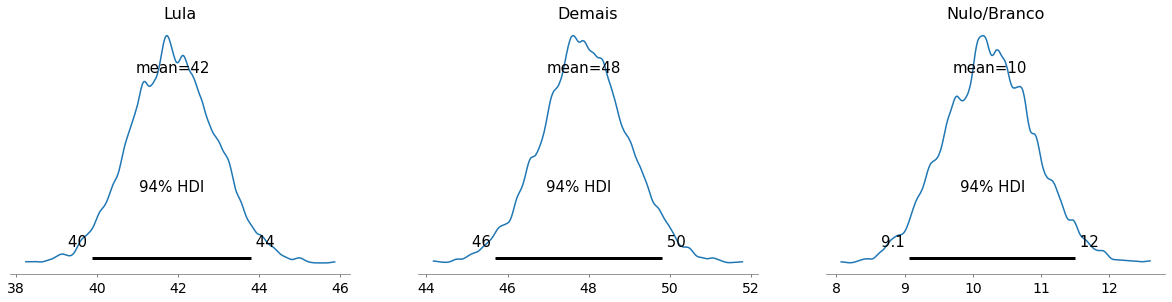

In [16]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

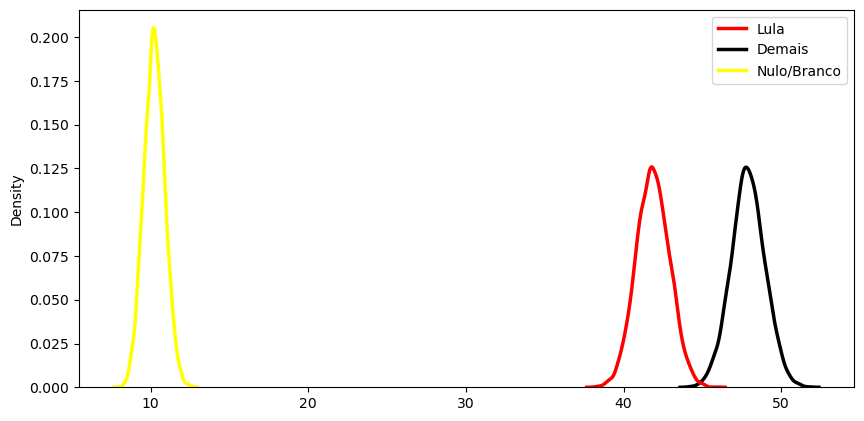

In [17]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [18]:
(post_pred['Lula'] > post_pred['Demais']).mean()

0.001

### Weekly update

In [19]:
flat_prior = prior = np.array([400.0, 130.0, 470.0])

# df_by_mes = df.groupby("mes").sum().reset_index()
# for obj in df_by_mes.itertuples():
df_results_weekly = pd.DataFrame({})
# print(df)

for obj in df.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    print(f">>> observed = {observed}")
    
    model_w = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    #model_w = build_model(prior, observed, rw_alpha_mult=2, rw_beta_mult=1.0)
    trace_w, ppc_w = sampling(model_w)
    posterior_w = ppc_w['current']
    
    prior = dirichlet.mle(posterior_w/posterior_w.sum(axis=1).reshape(-1, 1))
    
    qs = calc_prob_lula_win(model_w, trace_w, ppc=ppc_w)
    
    print(f">>> data_pesquisa={obj.data_pesquisa}, updaed_prior={prior},  qs={qs}% <<<");
    post_prob = posterior_w/posterior_w.sum(axis=1).reshape(-1, 1)
    df_results_weekly = df_results_weekly.append(pd.DataFrame({"data":[obj.data_pesquisa],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_weekly

>>> observed = [880 440 660]
1980
[400. 130. 470.]
[880 440 660]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-04, updaed_prior=[610.19699698 235.06220075 624.52242392],  qs=[33.535 34.28  35.1  ]% <<<
lula= [0.38989899 0.41565657 0.43989899]
nulo= [0.14141414 0.15959596 0.17979798]
demais= [0.4        0.42525253 0.45001263]
>>> observed = [990 288 783]
2061
[610.19699698 235.06220075 624.52242392]
[990 288 783]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-06, updaed_prior=[709.35363074 254.77381011 679.14280768],  qs=[78.435 79.06  79.78 ]% <<<
lula= [0.40756914 0.43134401 0.45560408]
nulo= [0.13731198 0.15526443 0.17224648]
demais= [0.39008976 0.41290636 0.43765163]
>>> observed = [ 704  270 1044]
2018
[709.35363074 254.77381011 679.14280768]
[ 704  270 1044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-19, updaed_prior=[656.60161233 239.5281643  698.17284125],  qs=[12.34   12.77   13.1725]% <<<
lula= [0.38800793 0.41179386 0.43658325]
nulo= [0.13280476 0.1506442  0.16750496]
demais= [0.41328048 0.43805748 0.46233895]
>>> observed = [ 740  142 1118]
2000
[656.60161233 239.5281643  698.17284125]
[ 740  142 1118]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-20, updaed_prior=[653.23368102 213.10576282 757.96616478],  qs=[0.185  0.26   0.3225]% <<<
lula= [0.378 0.402 0.427]
nulo= [0.1155 0.131  0.148 ]
demais= [0.443  0.4665 0.491 ]
>>> observed = [ 850  225 1400]
2475
[653.23368102 213.10576282 757.96616478]
[ 850  225 1400]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-24, updaed_prior=[737.33152449 228.7594866  943.4297913 ],  qs=[0. 0. 0.]% <<<
lula= [0.36484848 0.38585859 0.40848485]
nulo= [0.10545455 0.11959596 0.13454545]
demais= [0.47191919 0.49414141 0.51636364]
>>> observed = [1883  140 2376]
4399
[737.33152449 228.7594866  943.4297913 ]
[1883  140 2376]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-11-29, updaed_prior=[1286.22441451  278.39174776 1636.86056183],  qs=[0. 0. 0.]% <<<
lula= [0.3848602  0.40190952 0.41827688]
nulo= [0.07729029 0.08683792 0.09706752]
demais= [0.4939759  0.51125256 0.52830189]
>>> observed = [937 244 855]
2036
[1286.22441451  278.39174776 1636.86056183]
[937 244 855]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-05, updaed_prior=[721.39415233 161.24276752 879.08599509],  qs=[0.     0.     0.0225]% <<<
lula= [0.38654224 0.40962672 0.4327112 ]
nulo= [0.0780943  0.0913556  0.10462917]
demais= [0.47544204 0.49901768 0.52259332]
>>> observed = [444 156 600]
1200
[721.39415233 161.24276752 879.08599509]
[444 156 600]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-09, updaed_prior=[414.06190888  99.48323355 511.19858629],  qs=[0.02   0.06   0.1225]% <<<
lula= [0.37416667 0.40416667 0.435     ]
nulo= [0.07916667 0.09666667 0.11583333]
demais= [0.4675     0.49916667 0.53      ]
>>> observed = [856 306 838]
2000
[414.06190888  99.48323355 511.19858629]
[856 306 838]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-11, updaed_prior=[631.24976196 176.51623673 724.16382806],  qs=[0.445  0.55   0.6975]% <<<
lula= [0.3875 0.412  0.4375]
nulo= [0.099  0.115  0.1315]
demais= [0.448  0.473  0.4975]
>>> observed = [ 758  170 1072]
2000
[631.24976196 176.51623673 724.16382806]
[ 758  170 1072]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8821355596568043, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[649.09039793 172.93373926 783.30457001],  qs=[0.   0.01 0.03]% <<<
lula= [0.3805    0.4045    0.4280125]
nulo= [0.093  0.1075 0.1235]
demais= [0.464     0.488     0.5120125]
>>> observed = [960 280 760]
2000
[649.09039793 172.93373926 783.30457001]
[960 280 760]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-13, updaed_prior=[687.45674731 188.01095887 751.83801392],  qs=[4.05   4.39   4.7625]% <<<
lula= [0.3985 0.4225 0.446 ]
nulo= [0.1    0.1155 0.131 ]
demais= [0.4375 0.462  0.487 ]
>>> observed = [1759  366 1539]
3664
[687.45674731 188.01095887 751.83801392]
[1759  366 1539]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[1169.64724684  289.70847636 1178.28946039],  qs=[41.2325 42.07   42.6125]% <<<
lula= [0.42521834 0.44323144 0.46260917]
nulo= [0.09798035 0.10971616 0.12199782]
demais= [0.42740175 0.4470524  0.46533843]
>>> observed = [440 120 450]
1010
[1169.64724684  289.70847636 1178.28946039]
[440 120 450]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-16, updaed_prior=[406.9424411  101.81102202 410.83108669],  qs=[43.51  44.27  45.095]% <<<
lula= [0.40990099 0.44257426 0.47425743]
nulo= [0.09108911 0.11089109 0.13069307]
demais= [0.41386139 0.44653465 0.48019802]
>>> observed = [1200  330 1470]
3000
[406.9424411  101.81102202 410.83108669]
[1200  330 1470]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2021-12-21, updaed_prior=[856.13703513 223.03355757 942.59778746],  qs=[1.75   2.01   2.1925]% <<<
lula= [0.40233333 0.42333333 0.44466667]
nulo= [0.097 0.11  0.124]
demais= [0.444      0.46633333 0.48733333]
>>> observed = [900 240 820]
1960
[856.13703513 223.03355757 942.59778746]
[900 240 820]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.8790132244479879, but should be close to 0.8. Try to increase the number of tuning steps.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-09, updaed_prior=[702.8153955  183.95664822 745.25074073],  qs=[11.9625 12.62   13.4375]% <<<
lula= [0.40714286 0.43061224 0.45408163]
nulo= [0.09795918 0.1127551  0.12857143]
demais= [0.43316327 0.45663265 0.48112245]
>>> observed = [440 130 450]
1020
[702.8153955  183.95664822 745.25074073]
[440 130 450]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-12, updaed_prior=[396.45631429 105.6018632  418.56617064],  qs=[21.215  22.1    22.8925]% <<<
lula= [0.39901961 0.43039216 0.4627451 ]
nulo= [0.09411765 0.11470588 0.13529412]
demais= [0.42156863 0.45490196 0.48627451]
>>> observed = [615 165 705]
1485
[396.45631429 105.6018632  418.56617064]
[615 165 705]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-13, updaed_prior=[481.12959782 128.22258328 519.67722627],  qs=[ 9.9425 10.52   11.0925]% <<<
lula= [0.396633   0.42626263 0.45521886]
nulo= [0.09494949 0.11380471 0.13265993]
demais= [0.43164983 0.46060606 0.48956229]
>>> observed = [1260  360 1350]
2970
[481.12959782 128.22258328 519.67722627]
[1260  360 1350]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-18, updaed_prior=[891.54760074 244.46379236 959.38863815],  qs=[4.9875 5.43   5.7775]% <<<
lula= [0.4047138  0.42525253 0.44747475]
nulo= [0.1030303  0.11683502 0.13063973]
demais= [0.43703704 0.45791246 0.47878788]
>>> observed = [ 738  214 1044]
1996
[891.54760074 244.46379236 959.38863815]
[ 738  214 1044]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-21, updaed_prior=[682.03847653 189.17019374 773.94038798],  qs=[0.645 0.78  0.975]% <<<
lula= [0.39078156 0.41432866 0.43837675]
nulo= [0.1002004  0.11472946 0.13076152]
demais= [0.44639279 0.47044088 0.49549098]
>>> observed = [880 260 880]
2020
[682.03847653 189.17019374 773.94038798]
[880 260 880]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-01-25, updaed_prior=[680.65862633 192.045962   749.97419239],  qs=[2.975 3.23  3.685]% <<<
lula= [0.39554455 0.41980198 0.44306931]
nulo= [0.1029703  0.11831683 0.13417079]
demais= [0.43861386 0.46188119 0.48613861]
>>> observed = [1230  240 1530]
3000
[680.65862633 192.045962   749.97419239]
[1230  240 1530]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


  0%|          | 0/30 [00:00<?, ?it/s]

>>> data_pesquisa=2022-02-01, updaed_prior=[ 954.17604308  243.24867758 1094.1590543 ],  qs=[0.05  0.11  0.165]% <<<
lula= [0.39665833 0.41633333 0.43666667]
nulo= [0.09366667 0.106      0.11933333]
demais= [0.45733333 0.47733333 0.49733333]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389899,0.415657,0.439899,0.400000,0.425253,0.450013
0,2021-11-06,0.407569,0.431344,0.455604,0.390090,0.412906,0.437652
0,2021-11-19,0.388008,0.411794,0.436583,0.413280,0.438057,0.462339
0,2021-11-20,0.378000,0.402000,0.427000,0.443000,0.466500,0.491000
0,2021-11-24,0.364848,0.385859,0.408485,0.471919,0.494141,0.516364
0,2021-11-29,0.384860,0.401910,0.418277,0.493976,0.511253,0.528302
0,2021-12-05,0.386542,0.409627,0.432711,0.475442,0.499018,0.522593
0,2021-12-09,0.374167,0.404167,0.435000,0.467500,0.499167,0.530000
0,2021-12-11,0.387500,0.412000,0.437500,0.448000,0.473000,0.497500
0,2021-12-13,0.380500,0.404500,0.428012,0.464000,0.488000,0.512012


model = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)

>>> data_pesquisa=2022-01-13, updaed_prior=[483.38778278 128.66210683 523.97315797],  qs=[ 9.25   9.69  10.065]% <<<
lula= [0.396633   0.42558923 0.45454545]
nulo= [0.0956229  0.11313131 0.13265993]
demais= [0.43164983 0.46127946 0.49158249]

>>> data_pesquisa=2022-01-20, updaed_prior=[896.11772754 245.53127403 967.04329633],  qs=[4.64 4.95 5.32]% <<<
lula= [0.4037037  0.42491582 0.44612795]
nulo= [0.1030303  0.11649832 0.13030303]
demais= [0.43737374 0.45858586 0.47979798]

In [20]:
# az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(10,5));

In [21]:
az.summary(trace_w)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],6777.345,93.673,6607.428,6961.508,1.817,1.286,2687.0,2274.0,1.0
random_walk[1],1798.774,47.144,1712.484,1889.174,0.921,0.651,2617.0,2913.0,1.0
random_walk[2],7645.814,102.624,7449.414,7831.269,1.673,1.183,3768.0,2607.0,1.0
prior[0],0.417,0.005,0.407,0.427,0.000,0.000,2806.0,2627.0,1.0
prior[1],0.106,0.003,0.100,0.112,0.000,0.000,2473.0,2507.0,1.0
prior[2],0.477,0.005,0.468,0.487,0.000,0.000,3807.0,2877.0,1.0


In [22]:
# fig, ax = plt.subplots(2, figsize=(10,6))
lula_w = ppc_w['current'][:,0] / ppc_w['current'].sum(axis=1) * 100
nulo_w = ppc_w['current'][:,1] / ppc_w['current'].sum(axis=1) * 100.00
demais_w = ppc_w['current'][:,2] / ppc_w['current'].sum(axis=1) * 100
# az.plot_posterior({'Lula': lula, 'Demais': demais});
# az.plot_posterior({}, ax=ax[1])

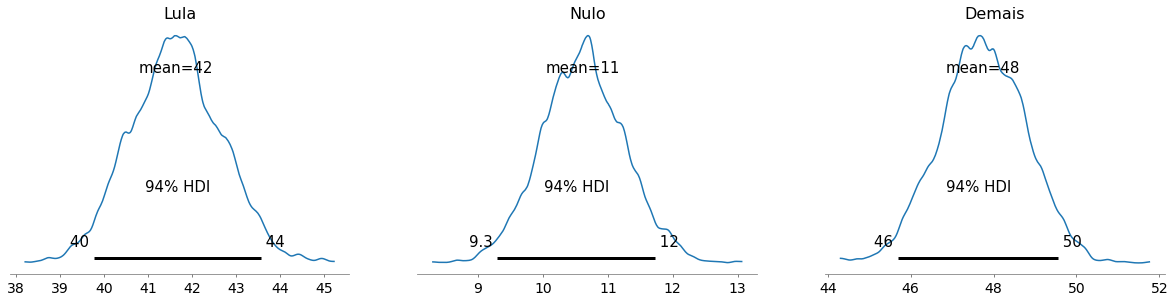

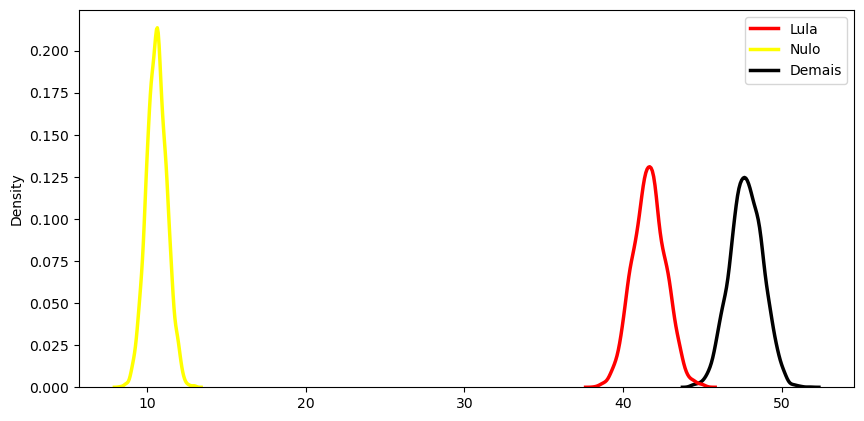

In [23]:
# a0 = np.array([100, 299, 100])
# D0 = np.random.dirichlet(a0, 1000)
# D0
post_pred_w = pd.DataFrame({'Lula': lula_w, 'Nulo': nulo_w, 'Demais': demais_w})
az.plot_posterior(post_pred_w.to_dict(orient='list'));
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)

sns.kdeplot(data=post_pred_w, ax=ax, palette=['red','yellow','black'], linewidth=2.5, gridsize=100);

In [24]:
df_results_weekly

,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,2021-11-04,0.389899,0.415657,0.439899,0.400000,0.425253,0.450013
0,2021-11-06,0.407569,0.431344,0.455604,0.390090,0.412906,0.437652
0,2021-11-19,0.388008,0.411794,0.436583,0.413280,0.438057,0.462339
0,2021-11-20,0.378000,0.402000,0.427000,0.443000,0.466500,0.491000
0,2021-11-24,0.364848,0.385859,0.408485,0.471919,0.494141,0.516364
0,2021-11-29,0.384860,0.401910,0.418277,0.493976,0.511253,0.528302
0,2021-12-05,0.386542,0.409627,0.432711,0.475442,0.499018,0.522593
0,2021-12-09,0.374167,0.404167,0.435000,0.467500,0.499167,0.530000
0,2021-12-11,0.387500,0.412000,0.437500,0.448000,0.473000,0.497500
0,2021-12-13,0.380500,0.404500,0.428012,0.464000,0.488000,0.512012


In [25]:
flat_prior = prior = np.array([420.0, 130.0, 450.0])

df_by_mes = df.groupby("mes").sum().reset_index()

for obj in df_by_mes.itertuples():
    observed = np.array([obj.LULA, obj.NULO, obj.OUTROS]).astype("int32")
    print(f">>> observed = {observed}")
    model_m = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)
    trace_m, ppc_m = sampling(model_m)
    posterior_m = ppc_m['current']
    prior = dirichlet.mle(posterior_m/posterior_m.sum(axis=1).reshape(-1, 1))
    qs = calc_prob_lula_win(model_m, trace_m, 50, ppc=ppc_m)
    print(f">>> mes={obj.mes}, updaed_prior={prior},  qs={[str(q)+'%' for q in qs]} <<<")
    post_prob = posterior_m/posterior_m.sum(axis=1).reshape(-1, 1)
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))



>>> observed = [6048 1507 7382]
14937
[420. 130. 450.]
[6048 1507 7382]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_11, updaed_prior=[3073.29352128  772.41114534 3739.07014512],  qs=['0.0%', '0.0%', '0.0%'] <<<
lula= [0.39398641 0.40516837 0.41634866]
nulo= [0.09506594 0.10182768 0.1088572 ]
demais= [0.48189061 0.49287005 0.50438508]
>>> observed = [7356 1973 7586]
16915
[3073.29352128  772.41114534 3739.07014512]
[7356 1973 7586]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2021_12, updaed_prior=[3996.74613164 1059.95471615 4249.93343233],  qs=['0.1825%', '0.27999999999999997%', '0.3925%'] <<<
lula= [0.41956695 0.42950044 0.43931422]
nulo= [0.10747709 0.11386343 0.1205439 ]
demais= [0.44664351 0.456577   0.46674549]
>>> observed = [4833 1369 5249]
11451
[3996.74613164 1059.95471615 4249.93343233]
[4833 1369 5249]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_01, updaed_prior=[2723.75162014  756.62431236 2938.02148778],  qs=['0.095%', '0.18%', '0.27999999999999997%'] <<<
lula= [0.41201642 0.42424242 0.43646843]
nulo= [0.11003406 0.11789363 0.12610471]
demais= [0.44554842 0.45777661 0.46974063]
>>> observed = [1230  240 1530]
3000
[2723.75162014  756.62431236 2938.02148778]
[1230  240 1530]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


  0%|          | 0/50 [00:00<?, ?it/s]

>>> mes=2022_02, updaed_prior=[831.54023073 198.3171014  962.85785306],  qs=['0.04%', '0.08%', '0.13749999999999998%'] <<<
lula= [0.39533333 0.41733333 0.43933333]
nulo= [0.08633333 0.09966667 0.112675  ]
demais= [0.46166667 0.483      0.50466667]


model = build_model(prior, observed, rw_alpha_mult=1.0, rw_beta_mult=1.0)


>>> mes=2021_12, updaed_prior=[4010.21159264 1063.82999647 4263.9625701 ],  qs=['0.1925%', '0.26%', '0.33999999999999997%'] <<<
lula= [0.4193896  0.42938221 0.43949305]
nulo= [0.10747857 0.11392255 0.1205439 ]
demais= [0.44670263 0.45651788 0.46668637]
>>> mes=2022_01, updaed_prior=[1986.94630475  542.79884705 2077.89947253],  qs=['7.24%', '7.6%', '8.0175%'] <<<
lula= [0.41708137 0.43120377 0.44559516]
nulo= [0.10867518 0.11782112 0.12723605]
demais= [0.43658373 0.45097512 0.46523201]

In [26]:
az.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],2701.036,48.274,2608.124,2788.777,0.872,0.617,3059.0,2313.0,1.0
random_walk[1],696.129,23.198,653.305,739.528,0.430,0.304,2906.0,2629.0,1.0
random_walk[2],3017.949,49.933,2927.056,3112.956,0.849,0.601,3456.0,2718.0,1.0
prior[0],0.417,0.006,0.405,0.429,0.000,0.000,2997.0,3194.0,1.0
prior[1],0.099,0.004,0.093,0.107,0.000,0.000,2438.0,2836.0,1.0
prior[2],0.483,0.006,0.471,0.495,0.000,0.000,3769.0,3653.0,1.0


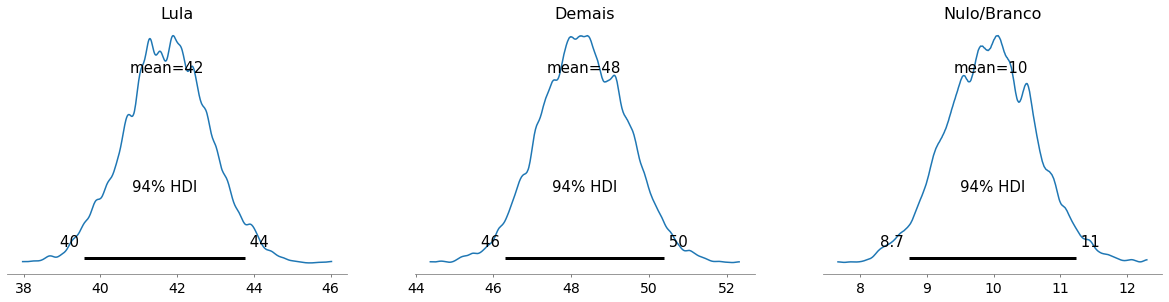

In [27]:
lula_m = ppc_m['current'][:,0] / ppc_m['current'].sum(axis=1) * 100.00
nulo_m = ppc_m['current'][:,1] / ppc_m['current'].sum(axis=1) * 100.00
demais_m = ppc_m['current'][:,2] / ppc_m['current'].sum(axis=1) * 100.00
post_pred = {'Lula': lula_m, 'Demais': demais_m, 'Nulo/Branco':nulo_m}
az.plot_posterior(post_pred);

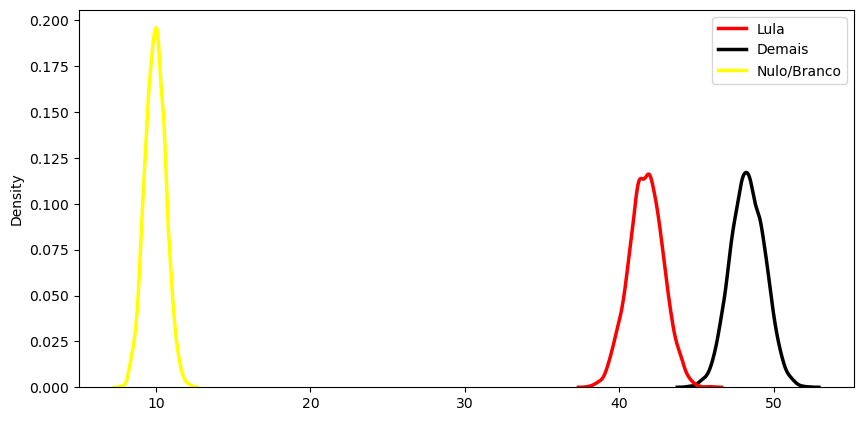

In [28]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
# ax.set_xlim(40, 50)
sns.kdeplot(data=post_pred, ax=ax, palette=['red','black','yellow'], linewidth=2.5, gridsize=500);

In [29]:
(post_pred['Lula'] > post_pred['Demais']).mean()

0.001

### DAILY

In [30]:
# for obj in df.itertuples():
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [17]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)
print(n_days)
print(poll_day.shape)

90
(21,)


In [32]:
# prior = np.array([435, 110, 455]) 
to_predict = np.zeros((n_days, 3)) * np.nan

to_predict[poll_day,:] = np.array([df.LULA, df.NULO, df.OUTROS]).astype("int32").T

flat_prior = prior = np.array([400.0, 130.0, 470.0])

df_results_daily = pd.DataFrame({})
day = -1
for obj in to_predict:
    day += 1
    observed = np.array([obj[0], obj[1], obj[2]])
    print(f">>> observed = {observed}")
    
    model_d = build_model(prior, observed, rw_alpha_mult=6.67, rw_beta_mult=0.667)
    trace_d, ppc_d = sampling(model_d)
    posterior_d = ppc_d['current']
    
    prior = dirichlet.mle(posterior_d/posterior_d.sum(axis=1).reshape(-1, 1))
    
    #qs = calc_prob_lula_win(model_d, trace_d, ppc=ppc_d)
    
    print(f">>> data_pesquisa={day}, updaed_prior={prior} <<<");
    post_prob = posterior_d/posterior_d.sum(axis=1).reshape(-1, 1)
    df_results_daily = df_results_daily.append(pd.DataFrame({"data":[day],
                                           "LulaLB":[np.quantile(post_prob[:, 0], q=HDI)[0]],
                                           "LulaM":[np.quantile(post_prob[:, 0], q=HDI)[1]],
                                           "LulaUB":[np.quantile(post_prob[:, 0], q=HDI)[2]],
                                           "DemaisLB":[np.quantile(post_prob[:, 2], q=HDI)[0]],
                                           "DemaisM":[np.quantile(post_prob[:, 2], q=HDI)[1]],
                                           "DemaisUB":[np.quantile(post_prob[:, 2], q=HDI)[2]]}))
    print(f"lula=", np.quantile(post_prob[:, 0], q=HDI))
    print(f"nulo=", np.quantile(post_prob[:, 1], q=HDI))
    print(f"demais=", np.quantile(post_prob[:, 2], q=HDI))
df_results_daily



>>> observed = [880. 440. 660.]
1980.0
[400. 130. 470.]
[880. 440. 660.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


>>> data_pesquisa=0, updaed_prior=[624.8519652  241.73238659 638.82381254] <<<
lula= [0.38989899 0.41515152 0.44040404]
nulo= [0.14191919 0.16060606 0.17979798]
demais= [0.39949495 0.42424242 0.4489899 ]
>>> observed = [nan nan nan]
1000
[624.8519652  241.73238659 638.82381254]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=1, updaed_prior=[365.42404944 140.10915134 376.15258141] <<<
lula= [0.382 0.415 0.447]
nulo= [0.135 0.159 0.184]
demais= [0.393 0.426 0.46 ]
>>> observed = [990. 288. 783.]
2061.0
[365.42404944 140.10915134 376.15258141]
[990. 288. 783.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


>>> data_pesquisa=2, updaed_prior=[651.8166213  225.97612128 608.58814659] <<<
lula= [0.41290636 0.43862203 0.4643377 ]
nulo= [0.13391557 0.15186803 0.17030568]
demais= [0.38427948 0.40950995 0.43426735]
>>> observed = [nan nan nan]
1000
[651.8166213  225.97612128 608.58814659]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=3, updaed_prior=[381.72670214 132.44839473 357.10904942] <<<
lula= [0.406 0.438 0.471]
nulo= [0.128 0.152 0.176]
demais= [0.378 0.41  0.443]
>>> observed = [nan nan nan]
1000
[381.72670214 132.44839473 357.10904942]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=4, updaed_prior=[351.43361049 121.03587226 328.13115721] <<<
lula= [0.405975 0.439    0.474   ]
nulo= [0.127 0.151 0.176]
demais= [0.376 0.41  0.445]
>>> observed = [nan nan nan]
1000
[351.43361049 121.03587226 328.13115721]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=5, updaed_prior=[344.20848182 117.39813186 319.86740602] <<<
lula= [0.406 0.44  0.475]
nulo= [0.126 0.15  0.177]
demais= [0.375 0.409 0.444]
>>> observed = [nan nan nan]
1000
[344.20848182 117.39813186 319.86740602]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=6, updaed_prior=[334.40408596 118.99414119 315.16694175] <<<
lula= [0.4   0.435 0.47 ]
nulo= [0.13  0.155 0.181]
demais= [0.375 0.41  0.445]
>>> observed = [nan nan nan]
1000
[334.40408596 118.99414119 315.16694175]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=7, updaed_prior=[326.45559261 114.93531992 307.89052789] <<<
lula= [0.4   0.436 0.47 ]
nulo= [0.128 0.153 0.18 ]
demais= [0.376 0.411 0.446]
>>> observed = [nan nan nan]
1000
[326.45559261 114.93531992 307.89052789]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=8, updaed_prior=[330.16422142 115.01763905 314.61298107] <<<
lula= [0.399 0.434 0.47 ]
nulo= [0.127 0.151 0.178]
demais= [0.38  0.414 0.449]
>>> observed = [nan nan nan]
1000
[330.16422142 115.01763905 314.61298107]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=9, updaed_prior=[327.57674147 118.36330711 314.72646267] <<<
lula= [0.396 0.431 0.467]
nulo= [0.13  0.155 0.183]
demais= [0.38  0.414 0.448]
>>> observed = [nan nan nan]
1000
[327.57674147 118.36330711 314.72646267]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=10, updaed_prior=[325.76554521 119.55411383 313.85156616] <<<
lula= [0.394 0.429 0.464]
nulo= [0.132 0.157 0.184]
demais= [0.379 0.414 0.448]
>>> observed = [nan nan nan]
1000
[325.76554521 119.55411383 313.85156616]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=11, updaed_prior=[335.66425735 125.95771002 317.51359673] <<<
lula= [0.396 0.431 0.466]
nulo= [0.136 0.162 0.187]
demais= [0.374 0.408 0.441]
>>> observed = [nan nan nan]
1000
[335.66425735 125.95771002 317.51359673]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=12, updaed_prior=[336.94463217 127.11014734 317.74310035] <<<
lula= [0.396 0.431 0.467]
nulo= [0.137 0.162 0.189]
demais= [0.372 0.406 0.441]
>>> observed = [nan nan nan]
1000
[336.94463217 127.11014734 317.74310035]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=13, updaed_prior=[335.93182044 125.84197501 316.65598161] <<<
lula= [0.398 0.431 0.466]
nulo= [0.136 0.161 0.188]
demais= [0.372 0.407 0.44 ]
>>> observed = [nan nan nan]
1000
[335.93182044 125.84197501 316.65598161]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=14, updaed_prior=[309.23271222 115.24183531 294.62359567] <<<
lula= [0.395 0.43  0.465]
nulo= [0.133 0.16  0.189]
demais= [0.376 0.409 0.446]
>>> observed = [ 704.  270. 1044.]
2018.0
[309.23271222 115.24183531 294.62359567]
[ 704.  270. 1044.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


>>> data_pesquisa=15, updaed_prior=[557.99013771 209.9917767  638.58233091] <<<
lula= [0.3716551  0.39643211 0.4222002 ]
nulo= [0.1308226  0.14915758 0.16798811]
demais= [0.42765114 0.45391477 0.48017839]
>>> observed = [ 740.  142. 1118.]
2000.0
[557.99013771 209.9917767  638.58233091]
[ 740.  142. 1118.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


>>> data_pesquisa=16, updaed_prior=[604.3530604  198.91826161 746.41154861] <<<
lula= [0.366 0.39  0.414]
nulo= [0.112  0.1285 0.145 ]
demais= [0.456     0.482     0.5060125]
>>> observed = [nan nan nan]
1000
[604.3530604  198.91826161 746.41154861]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=17, updaed_prior=[345.46778922 112.22935874 424.73933431] <<<
lula= [0.36  0.392 0.424]
nulo= [0.106 0.127 0.15 ]
demais= [0.448 0.481 0.514]
>>> observed = [nan nan nan]
1000
[345.46778922 112.22935874 424.73933431]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=18, updaed_prior=[320.57806083 101.08485286 388.86812785] <<<
lula= [0.362 0.395 0.43 ]
nulo= [0.102 0.125 0.148]
demais= [0.446 0.48  0.514]
>>> observed = [nan nan nan]
1000
[320.57806083 101.08485286 388.86812785]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=19, updaed_prior=[307.5748192   95.95116866 373.13504782] <<<
lula= [0.363 0.396 0.43 ]
nulo= [0.1   0.124 0.148]
demais= [0.446 0.48  0.514]
>>> observed = [ 850.  225. 1400.]
2475.0
[307.5748192   95.95116866 373.13504782]
[ 850.  225. 1400.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


>>> data_pesquisa=20, updaed_prior=[619.78223209 181.06062879 862.11895684] <<<
lula= [0.34949495 0.37292929 0.3959596 ]
nulo= [0.09454545 0.10868687 0.12405051]
demais= [0.49414141 0.51838384 0.54262626]
>>> observed = [nan nan nan]
1000
[619.78223209 181.06062879 862.11895684]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=21, updaed_prior=[323.53930705  92.99122853 451.0828714 ] <<<
lula= [0.341 0.373 0.405]
nulo= [0.087 0.107 0.128]
demais= [0.487    0.52     0.552025]
>>> observed = [nan nan nan]
1000
[323.53930705  92.99122853 451.0828714 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=22, updaed_prior=[298.88977056  83.53099538 419.38573401] <<<
lula= [0.341 0.373 0.406]
nulo= [0.083 0.104 0.126]
demais= [0.488 0.523 0.558]
>>> observed = [nan nan nan]
1000
[298.88977056  83.53099538 419.38573401]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The acceptance probability does not match the target. It is 0.8865049888694957, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=23, updaed_prior=[283.77069739  79.22686671 399.25087493] <<<
lula= [0.339 0.372 0.406]
nulo= [0.082 0.104 0.127]
demais= [0.49  0.524 0.558]
>>> observed = [nan nan nan]
1000
[283.77069739  79.22686671 399.25087493]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=24, updaed_prior=[296.00585979  83.20631994 414.35861729] <<<
lula= [0.34  0.373 0.407]
nulo= [0.084 0.104 0.127]
demais= [0.488 0.522 0.558]
>>> observed = [1883.  140. 2376.]
4399.0
[296.00585979  83.20631994 414.35861729]
[1883.  140. 2376.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


>>> data_pesquisa=25, updaed_prior=[1135.7114079   171.59365514 1493.25271368] <<<
lula= [0.38713344 0.40554672 0.42350534]
nulo= [0.05251193 0.06115026 0.07024324]
demais= [0.51488975 0.5330757  0.55126165]
>>> observed = [nan nan nan]
1000
[1135.7114079   171.59365514 1493.25271368]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=26, updaed_prior=[377.44842685  56.73923325 497.46154015] <<<
lula= [0.374 0.405 0.437]
nulo= [0.046 0.061 0.077]
demais= [0.502 0.534 0.566]
>>> observed = [nan nan nan]
1000
[377.44842685  56.73923325 497.46154015]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=27, updaed_prior=[323.17343304  48.42729561 423.2720882 ] <<<
lula= [0.374 0.406 0.44 ]
nulo= [0.045 0.061 0.078]
demais= [0.498 0.533 0.567]
>>> observed = [nan nan nan]
1000
[323.17343304  48.42729561 423.2720882 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=28, updaed_prior=[310.23825822  46.89676901 408.54131335] <<<
lula= [0.37  0.405 0.441]
nulo= [0.045 0.061 0.079]
demais= [0.499  0.5335 0.568 ]
>>> observed = [nan nan nan]
1000
[310.23825822  46.89676901 408.54131335]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=29, updaed_prior=[314.33384594  47.6069035  413.82114774] <<<
lula= [0.372 0.405 0.439]
nulo= [0.045 0.061 0.079]
demais= [0.497 0.533 0.568]
>>> observed = [nan nan nan]
1000
[314.33384594  47.6069035  413.82114774]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=30, updaed_prior=[312.15923522  47.88602819 416.61155069] <<<
lula= [0.368 0.402 0.437]
nulo= [0.046 0.061 0.079]
demais= [0.501 0.536 0.571]
>>> observed = [937. 244. 855.]
2036.0
[312.15923522  47.88602819 416.61155069]
[937. 244. 855.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


>>> data_pesquisa=31, updaed_prior=[621.06785594 122.9746332  715.68523892] <<<
lula= [0.4002947  0.42534381 0.45088409]
nulo= [0.07072692 0.08398821 0.09872299]
demais= [0.46463654 0.49017682 0.51620825]
>>> observed = [nan nan nan]
1000
[621.06785594 122.9746332  715.68523892]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=32, updaed_prior=[374.53396468  74.84017958 427.96021277] <<<
lula= [0.394 0.427 0.458]
nulo= [0.067 0.085 0.104]
demais= [0.455975 0.488    0.521   ]
>>> observed = [nan nan nan]
1000
[374.53396468  74.84017958 427.96021277]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=33, updaed_prior=[327.89274844  63.43401614 373.31915935] <<<
lula= [0.394 0.429 0.464]
nulo= [0.064 0.083 0.103]
demais= [0.453 0.488 0.524]
>>> observed = [nan nan nan]
1000
[327.89274844  63.43401614 373.31915935]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=34, updaed_prior=[329.62136044  64.64631733 378.52767269] <<<
lula= [0.391 0.427 0.462]
nulo= [0.065    0.083    0.103025]
demais= [0.454 0.49  0.526]
>>> observed = [444. 156. 600.]
1200.0
[329.62136044  64.64631733 378.52767269]
[444. 156. 600.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


>>> data_pesquisa=35, updaed_prior=[387.90831432  91.1214832  465.46405659] <<<
lula= [0.37997917 0.41083333 0.44166667]
nulo= [0.07833333 0.09583333 0.11585417]
demais= [0.46       0.49333333 0.52416667]
>>> observed = [nan nan nan]
1000
[387.90831432  91.1214832  465.46405659]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=36, updaed_prior=[334.06974743  78.57742825 404.68013582] <<<
lula= [0.375975 0.408    0.442025]
nulo= [0.076975 0.096    0.117   ]
demais= [0.461 0.495 0.53 ]
>>> observed = [856. 306. 838.]
2000.0
[334.06974743  78.57742825 404.68013582]
[856. 306. 838.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=37, updaed_prior=[598.12426929 168.98734314 670.86492199] <<<
lula= [0.39  0.416 0.441]
nulo= [0.1005 0.1175 0.1345]
demais= [0.441     0.4665    0.4915125]
>>> observed = [nan nan nan]
1000
[598.12426929 168.98734314 670.86492199]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=38, updaed_prior=[345.0475115   97.17943385 389.90824473] <<<
lula= [0.382 0.414 0.449]
nulo= [0.096 0.117 0.139]
demais= [0.433 0.469 0.502]
>>> observed = [960. 280. 760.]
2000.0
[345.0475115   97.17943385 389.90824473]
[960. 280. 760.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=39, updaed_prior=[630.19384238 180.10022291 623.93826003] <<<
lula= [0.414  0.4395 0.4645]
nulo= [0.1085 0.1255 0.143 ]
demais= [0.4085 0.435  0.461 ]
>>> observed = [nan nan nan]
1000
[630.19384238 180.10022291 623.93826003]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=40, updaed_prior=[371.61059661 107.02605219 367.00749329] <<<
lula= [0.407 0.439 0.473]
nulo= [0.104    0.127    0.149025]
demais= [0.401 0.434 0.468]
>>> observed = [nan nan nan]
1000
[371.61059661 107.02605219 367.00749329]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=41, updaed_prior=[333.64480663  95.01848422 331.3835535 ] <<<
lula= [0.403 0.439 0.475]
nulo= [0.103 0.125 0.148]
demais= [0.4   0.436 0.472]
>>> observed = [440. 120. 450.]
1010.0
[333.64480663  95.01848422 331.3835535 ]
[440. 120. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=42, updaed_prior=[354.90062279  99.86420871 355.11855974] <<<
lula= [0.4049505  0.43861386 0.47227723]
nulo= [0.1        0.12376238 0.14653465]
demais= [0.4049505  0.43861386 0.47227723]
>>> observed = [nan nan nan]
1000
[354.90062279  99.86420871 355.11855974]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=43, updaed_prior=[346.55987559  97.8605882  342.84682302] <<<
lula= [0.406 0.44  0.477]
nulo= [0.102 0.124 0.148]
demais= [0.401 0.435 0.47 ]
>>> observed = [nan nan nan]
1000
[346.55987559  97.8605882  342.84682302]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=44, updaed_prior=[341.12706364  95.06049752 339.0000637 ] <<<
lula= [0.406 0.44  0.475]
nulo= [0.1   0.123 0.146]
demais= [0.401 0.437 0.472]
>>> observed = [nan nan nan]
1000
[341.12706364  95.06049752 339.0000637 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=45, updaed_prior=[336.44890776  96.257643   338.0687588 ] <<<
lula= [0.402 0.437 0.472]
nulo= [0.102 0.125 0.148]
demais= [0.404 0.438 0.474]
>>> observed = [nan nan nan]
1000
[336.44890776  96.257643   338.0687588 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=46, updaed_prior=[330.05385516  94.66570131 334.35157687] <<<
lula= [0.4   0.435 0.471]
nulo= [0.102 0.125 0.149]
demais= [0.407 0.44  0.476]
>>> observed = [1200.  330. 1470.]
3000.0
[330.05385516  94.66570131 334.35157687]
[1200.  330. 1470.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


>>> data_pesquisa=47, updaed_prior=[817.37356839 229.9545356  910.05170009] <<<
lula= [0.39565833 0.41766667 0.43900833]
nulo= [0.10366667 0.11733333 0.13266667]
demais= [0.44333333 0.465      0.48633333]
>>> observed = [nan nan nan]
1000
[817.37356839 229.9545356  910.05170009]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=48, updaed_prior=[371.11682148 103.66254536 413.65656462] <<<
lula= [0.385    0.418    0.450025]
nulo= [0.096 0.117 0.138]
demais= [0.433 0.466 0.499]
>>> observed = [nan nan nan]
1000
[371.11682148 103.66254536 413.65656462]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=49, updaed_prior=[329.82228898  91.70834325 364.63835715] <<<
lula= [0.385    0.42     0.454025]
nulo= [0.095 0.117 0.14 ]
demais= [0.429 0.464 0.499]
>>> observed = [nan nan nan]
1000
[329.82228898  91.70834325 364.63835715]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=50, updaed_prior=[328.34055197  89.33036656 364.85490592] <<<
lula= [0.385 0.419 0.455]
nulo= [0.092 0.114 0.137]
demais= [0.432    0.466    0.500025]
>>> observed = [nan nan nan]
1000
[328.34055197  89.33036656 364.85490592]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=51, updaed_prior=[325.55894805  90.99958903 357.58297082] <<<
lula= [0.386 0.421 0.455]
nulo= [0.095 0.118 0.14 ]
demais= [0.427 0.462 0.496]
>>> observed = [nan nan nan]
1000
[325.55894805  90.99958903 357.58297082]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=52, updaed_prior=[322.25665875  90.36053621 350.5405261 ] <<<
lula= [0.388 0.422 0.457]
nulo= [0.096 0.118 0.142]
demais= [0.424 0.459 0.495]
>>> observed = [nan nan nan]
1000
[322.25665875  90.36053621 350.5405261 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=53, updaed_prior=[327.96070657  91.28772688 356.49920629] <<<
lula= [0.388 0.423 0.457]
nulo= [0.095 0.118 0.141]
demais= [0.425 0.46  0.495]
>>> observed = [nan nan nan]
1000
[327.96070657  91.28772688 356.49920629]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=54, updaed_prior=[320.96224091  90.95281855 351.29146648] <<<
lula= [0.385 0.421 0.455]
nulo= [0.097 0.119 0.143]
demais= [0.425 0.46  0.496]
>>> observed = [nan nan nan]
1000
[320.96224091  90.95281855 351.29146648]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=55, updaed_prior=[316.67687429  89.60306155 345.75621792] <<<
lula= [0.385 0.421 0.456]
nulo= [0.097 0.119 0.143]
demais= [0.424 0.46  0.496]
>>> observed = [nan nan nan]
1000
[316.67687429  89.60306155 345.75621792]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=56, updaed_prior=[327.6270031   90.52342102 355.28036671] <<<
lula= [0.389 0.424 0.458]
nulo= [0.095 0.117 0.14 ]
demais= [0.425 0.459 0.494]
>>> observed = [nan nan nan]
1000
[327.6270031   90.52342102 355.28036671]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=57, updaed_prior=[327.56289313  89.20636248 354.41762168] <<<
lula= [0.39  0.425 0.461]
nulo= [0.094 0.116 0.139]
demais= [0.424 0.46  0.494]
>>> observed = [nan nan nan]
1000
[327.56289313  89.20636248 354.41762168]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=58, updaed_prior=[325.40341198  90.46754471 354.97748948] <<<
lula= [0.387 0.422 0.458]
nulo= [0.095 0.118 0.14 ]
demais= [0.426 0.46  0.495]
>>> observed = [nan nan nan]
1000
[325.40341198  90.46754471 354.97748948]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=59, updaed_prior=[326.20278576  90.90820024 354.82430604] <<<
lula= [0.388 0.423 0.458]
nulo= [0.096 0.117 0.141]
demais= [0.426 0.459 0.494]
>>> observed = [nan nan nan]
1000
[326.20278576  90.90820024 354.82430604]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=60, updaed_prior=[330.53734941  94.35312934 365.4781068 ] <<<
lula= [0.383 0.418 0.452]
nulo= [0.097 0.119 0.142]
demais= [0.428 0.462 0.498]
>>> observed = [nan nan nan]
1000
[330.53734941  94.35312934 365.4781068 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=61, updaed_prior=[316.94847388  91.96078448 351.10937749] <<<
lula= [0.382 0.417 0.453]
nulo= [0.098 0.121 0.144]
demais= [0.427 0.462 0.497]
>>> observed = [nan nan nan]
1000
[316.94847388  91.96078448 351.10937749]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=62, updaed_prior=[322.70688026  96.46413458 360.87935249] <<<
lula= [0.379 0.414 0.449]
nulo= [0.101    0.123    0.147025]
demais= [0.428975 0.463    0.497025]
>>> observed = [nan nan nan]
1000
[322.70688026  96.46413458 360.87935249]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=63, updaed_prior=[326.80673228  97.07916239 364.84035825] <<<
lula= [0.378 0.414 0.449]
nulo= [0.1   0.123 0.146]
demais= [0.428 0.463 0.499]
>>> observed = [nan nan nan]
1000
[326.80673228  97.07916239 364.84035825]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=64, updaed_prior=[321.95915179  93.90821162 359.12904057] <<<
lula= [0.381 0.415 0.451]
nulo= [0.099 0.121 0.144]
demais= [0.429 0.463 0.499]
>>> observed = [nan nan nan]
1000
[321.95915179  93.90821162 359.12904057]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=65, updaed_prior=[332.92221737  97.87329924 365.94488338] <<<
lula= [0.383 0.418 0.452]
nulo= [0.100975 0.123    0.146   ]
demais= [0.425 0.459 0.494]
>>> observed = [900. 240. 820.]
1960.0
[332.92221737  97.87329924 365.94488338]
[900. 240. 820.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=66, updaed_prior=[600.17649013 169.52127479 614.22503183] <<<
lula= [0.40815051 0.43367347 0.46020408]
nulo= [0.10561224 0.12244898 0.14030612]
demais= [0.41734694 0.44387755 0.46938776]
>>> observed = [nan nan nan]
1000
[600.17649013 169.52127479 614.22503183]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=67, updaed_prior=[366.01703785 104.17418422 372.47287196] <<<
lula= [0.401 0.434 0.467]
nulo= [0.101 0.123 0.147]
demais= [0.408 0.442 0.475]
>>> observed = [nan nan nan]
1000
[366.01703785 104.17418422 372.47287196]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=68, updaed_prior=[351.5181144   97.19951324 358.43185281] <<<
lula= [0.401 0.436 0.47 ]
nulo= [0.098 0.12  0.143]
demais= [0.411 0.444 0.478]
>>> observed = [440. 130. 450.]
1020.0
[351.5181144   97.19951324 358.43185281]
[440. 130. 450.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


>>> data_pesquisa=69, updaed_prior=[352.58918907  99.17361936 359.48608326] <<<
lula= [0.40196078 0.43431373 0.46862745]
nulo= [0.10098039 0.12156863 0.14607843]
demais= [0.40882353 0.44313725 0.47843137]
>>> observed = [615. 165. 705.]
1485.0
[352.58918907  99.17361936 359.48608326]
[615. 165. 705.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


>>> data_pesquisa=70, updaed_prior=[481.36721826 133.22439022 509.33795662] <<<
lula= [0.3993266  0.42828283 0.45589226]
nulo= [0.0996633  0.11851852 0.13804714]
demais= [0.42424242 0.45319865 0.48215488]
>>> observed = [nan nan nan]
1000
[481.36721826 133.22439022 509.33795662]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=71, updaed_prior=[349.07710376  98.23303842 370.0970649 ] <<<
lula= [0.393 0.427 0.46 ]
nulo= [0.098 0.12  0.143]
demais= [0.42  0.453 0.487]
>>> observed = [nan nan nan]
1000
[349.07710376  98.23303842 370.0970649 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=72, updaed_prior=[341.39119073  94.82004402 360.67513489] <<<
lula= [0.394    0.428    0.463025]
nulo= [0.096 0.119 0.143]
demais= [0.418 0.453 0.487]
>>> observed = [nan nan nan]
1000
[341.39119073  94.82004402 360.67513489]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=73, updaed_prior=[335.3370847   91.0473416  352.17345036] <<<
lula= [0.395 0.431 0.466]
nulo= [0.096 0.117 0.139]
demais= [0.417 0.452 0.488]
>>> observed = [nan nan nan]
1000
[335.3370847   91.0473416  352.17345036]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=74, updaed_prior=[332.12638132  92.11998298 353.75680333] <<<
lula= [0.392 0.427 0.461]
nulo= [0.096 0.118 0.142]
demais= [0.421 0.455 0.49 ]
>>> observed = [1260.  360. 1350.]
2970.0
[332.12638132  92.11998298 353.75680333]
[1260.  360. 1350.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


>>> data_pesquisa=75, updaed_prior=[835.77806536 235.37886326 893.30479328] <<<
lula= [0.4040404  0.42558923 0.44747475]
nulo= [0.10538721 0.11986532 0.13434343]
demais= [0.43333333 0.45488215 0.47643098]
>>> observed = [nan nan nan]
1000
[835.77806536 235.37886326 893.30479328]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=76, updaed_prior=[381.43836972 107.56126118 407.96161623] <<<
lula= [0.393 0.425 0.457]
nulo= [0.099 0.12  0.142]
demais= [0.424 0.454 0.487]
>>> observed = [nan nan nan]
1000
[381.43836972 107.56126118 407.96161623]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=77, updaed_prior=[340.00953366  94.99681753 366.06892176] <<<
lula= [0.391 0.424 0.458]
nulo= [0.097 0.118 0.142]
demais= [0.423 0.457 0.491]
>>> observed = [ 738.  214. 1044.]
1996.0
[340.00953366  94.99681753 366.06892176]
[ 738.  214. 1044.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


>>> data_pesquisa=78, updaed_prior=[566.0195989  160.37876928 677.00924279] <<<
lula= [0.37825651 0.40330661 0.42885772]
nulo= [0.09769539 0.11422846 0.13126253]
demais= [0.45591182 0.48246493 0.50801603]
>>> observed = [nan nan nan]
1000
[566.0195989  160.37876928 677.00924279]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=79, updaed_prior=[337.98399393  96.060485   405.47415373] <<<
lula= [0.369 0.402 0.437]
nulo= [0.093    0.114    0.136025]
demais= [0.449 0.483 0.516]
>>> observed = [nan nan nan]
1000
[337.98399393  96.060485   405.47415373]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=80, updaed_prior=[319.71799655  89.29548993 374.80347045] <<<
lula= [0.374 0.408 0.441]
nulo= [0.093 0.114 0.136]
demais= [0.444 0.478 0.513]
>>> observed = [nan nan nan]
1000
[319.71799655  89.29548993 374.80347045]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=81, updaed_prior=[325.13037563  89.11263215 382.71587033] <<<
lula= [0.375 0.408 0.442]
nulo= [0.09  0.112 0.135]
demais= [0.446    0.48     0.514025]
>>> observed = [880. 260. 880.]
2020.0
[325.13037563  89.11263215 382.71587033]
[880. 260. 880.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


>>> data_pesquisa=82, updaed_prior=[606.31341483 171.54699439 670.39519917] <<<
lula= [0.39306931 0.41881188 0.44356436]
nulo= [0.10246287 0.11831683 0.13514851]
demais= [0.43762376 0.46287129 0.48910891]
>>> observed = [nan nan nan]
1000
[606.31341483 171.54699439 670.39519917]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=83, updaed_prior=[351.30085525  98.84935794 389.3540239 ] <<<
lula= [0.385    0.419    0.451025]
nulo= [0.096 0.118 0.14 ]
demais= [0.43  0.464 0.497]
>>> observed = [nan nan nan]
1000
[351.30085525  98.84935794 389.3540239 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=84, updaed_prior=[347.85579245  95.19785948 379.5956378 ] <<<
lula= [0.389 0.423 0.456]
nulo= [0.094 0.116 0.138]
demais= [0.428    0.462    0.495025]
>>> observed = [nan nan nan]
1000
[347.85579245  95.19785948 379.5956378 ]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=85, updaed_prior=[323.56708249  88.23995639 354.28066969] <<<
lula= [0.388975 0.422    0.457   ]
nulo= [0.093 0.115 0.139]
demais= [0.429 0.462 0.498]
>>> observed = [nan nan nan]
1000
[323.56708249  88.23995639 354.28066969]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=86, updaed_prior=[316.15207226  87.09972424 339.69144082] <<<
lula= [0.391 0.425 0.461]
nulo= [0.093 0.117 0.141]
demais= [0.423 0.457 0.491]
>>> observed = [nan nan nan]
1000
[316.15207226  87.09972424 339.69144082]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=87, updaed_prior=[333.12577716  91.69569768 346.54116974] <<<
lula= [0.397 0.432 0.466]
nulo= [0.096 0.119 0.143]
demais= [0.415 0.449 0.485]
>>> observed = [nan nan nan]
1000
[333.12577716  91.69569768 346.54116974]
[nan nan nan]


/mnt/home/regis/anaconda3/envs/kaggle_env/lib/python3.9/site-packages/pymc3/model.py:1755: ImputationWarning: Data in current contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [prior, random_walk]
>Metropolis: [current_missing]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


>>> data_pesquisa=88, updaed_prior=[334.20130523  90.92166788 351.18514912] <<<
lula= [0.396 0.431 0.465]
nulo= [0.094 0.117 0.141]
demais= [0.419    0.452    0.487025]
>>> observed = [1230.  240. 1530.]
3000.0
[334.20130523  90.92166788 351.18514912]
[1230.  240. 1530.]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


>>> data_pesquisa=89, updaed_prior=[842.70165737 198.03357148 963.12707242] <<<
lula= [0.39866667 0.42066667 0.441675  ]
nulo= [0.086      0.09866667 0.112     ]
demais= [0.45966667 0.48066667 0.502675  ]


,data,LulaLB,LulaM,LulaUB,DemaisLB,DemaisM,DemaisUB
0,0,0.389899,0.415152,0.440404,0.399495,0.424242,0.448990
0,1,0.382000,0.415000,0.447000,0.393000,0.426000,0.460000
0,2,0.412906,0.438622,0.464338,0.384279,0.409510,0.434267
0,3,0.406000,0.438000,0.471000,0.378000,0.410000,0.443000
0,4,0.405975,0.439000,0.474000,0.376000,0.410000,0.445000
0,5,0.406000,0.440000,0.475000,0.375000,0.409000,0.444000
0,6,0.400000,0.435000,0.470000,0.375000,0.410000,0.445000
0,7,0.400000,0.436000,0.470000,0.376000,0.411000,0.446000
0,8,0.399000,0.434000,0.470000,0.380000,0.414000,0.449000
0,9,0.396000,0.431000,0.467000,0.380000,0.414000,0.448000


In [33]:
trace_d, ppc_d = sampling(model_d)
posterior_d = ppc_d['current']
az.summary(trace_d)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior, random_walk]
Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
random_walk[0],3293.080,63.461,3174.183,3408.530,1.093,0.773,3359.0,2702.0,1.0
random_walk[1],821.819,29.777,765.646,877.091,0.553,0.391,2909.0,1984.0,1.0
random_walk[2],3640.932,67.653,3515.285,3770.644,1.115,0.789,3676.0,2622.0,1.0
prior[0],0.420,0.006,0.408,0.432,0.000,0.000,2788.0,2993.0,1.0
prior[1],0.099,0.004,0.091,0.106,0.000,0.000,2645.0,2137.0,1.0
prior[2],0.481,0.006,0.469,0.492,0.000,0.000,3548.0,3370.0,1.0


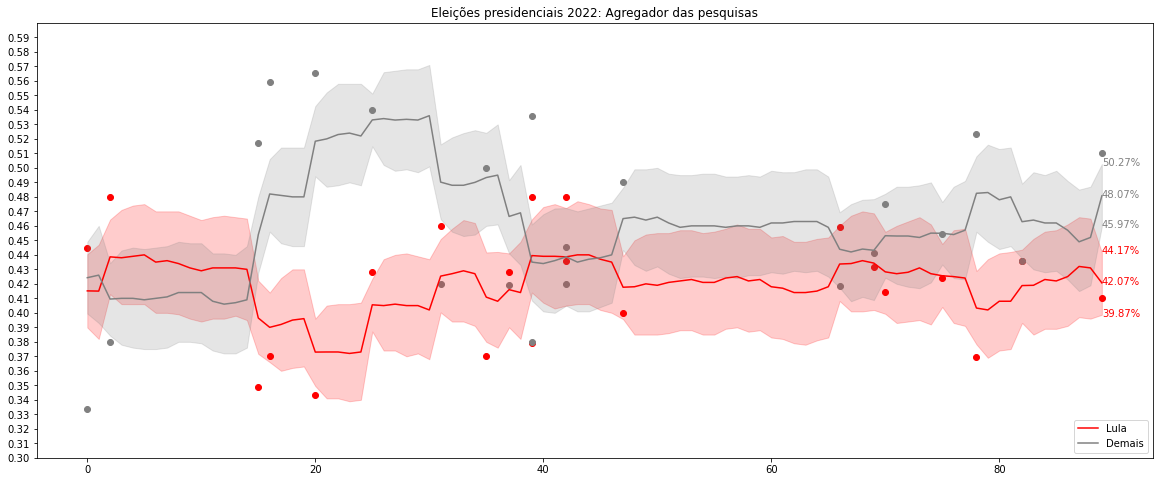

In [34]:
dfrw = df_results_daily.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))

plt.scatter(dfrw.data[poll_day], df.LULA/df.TOTAL, color='red')
plt.scatter(dfrw.data[poll_day], df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.show()

## Playground

In [35]:
import math
1 - stats.norm.cdf(0, loc=-1, scale=math.sqrt(5))

0.32736042300928847

In [36]:
import scipy as sp
true_p = sp.stats.dirichlet(6.0 * np.array([0.45, 0.3, 0.15, 0.9, 0.01])).rvs(size=10)
observed = np.vstack([sp.stats.multinomial(n=50, p=p_i).rvs() for p_i in true_p])



In [37]:
observed.sum(axis=1)

array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50])

In [38]:
import ipywidgets as widgets
from ipywidgets import interact
from datetime import datetime
import plotly.io as pio
# Default is plotly_mimetype+notebook, but jekyll fails to parse plotly_mimetype.
pio.renderers.default = 'notebook_connected'

# Inject the missing require.js dependency.
from IPython.display import display, HTML
js = '<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.6/require.min.js" integrity="sha512-c3Nl8+7g4LMSTdrm621y7kf9v3SDPnhxLNhcjFJbKECVnmZHTdo+IRO05sNLTH/D3vA6u1X32ehoLC7WFVdheg==" crossorigin="anonymous"></script>'
display(HTML(js))
import plotly.express as px

# df_gm = px.data.gapminder()
# px.scatter(df_gm, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
#            size="pop", color="continent", hover_name="country",
#            log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])


In [39]:
# hide_input
# This cell is required for the export to HTML to work.


In [40]:
observed_prior = np.array([7356., 1973., 7578.])
prior = []
N = 4000
for it in range(N):
    b = stats.beta.rvs(a=5, b=1, size=3)
    # print(b)
    # print(observed_prior * b)
    diric = stats.dirichlet.rvs(observed_prior * b,)
    # print(diric[0])
    prior.append(diric[0])
prior = np.array(prior)
print(prior[:4])

[[0.39555127 0.12240872 0.48204001]
 [0.42214073 0.11667742 0.46118185]
 [0.37548353 0.16068079 0.46383568]
 [0.48537601 0.11856733 0.39605665]]


In [41]:

print((prior[:,0] > prior[:,2]).mean())
print(prior.shape)


0.4205
(4000, 3)


In [42]:
posterior = []
for it in range(N):
    mn = stats.multinomial.rvs(n=3000, p=[1340/3000, 370/3000, 1290/3000])
    posterior.append(mn * prior[it])
posterior = np.array(posterior)



In [43]:
post = posterior#/posterior.sum(axis=1).reshape(4000,1)
print(post.sum(axis=1))
print(post[:10, 0])
print(post[:10, 2])

[1202.61071202 1199.58385117 1159.93624357 ... 1194.43325476 1215.02321396
 1204.93916266]
[536.36751946 569.88998983 497.14018955 670.30427501 612.17881568
 548.12564674 608.66924614 564.66047607 474.51494291 618.42102588]
[623.27773049 585.23976463 602.05871485 506.55646078 561.6581887
 643.01708862 585.73236616 580.72640056 674.09135822 588.76793538]


In [44]:
lula = post[:, 0]
others = post[:, 2]
print((lula > others).mean())

0.50225


In [45]:
simul = []
for it in range(N):
    idx = np.random.choice(N,1)[0]
    #print(idx)
    #print(post[idx])
    dir2 = stats.dirichlet.rvs(post[idx])[0]
    simul.append(dir2)
dir2 = np.array(simul)

In [46]:
dir2

array([[0.55144331, 0.03826189, 0.4102948 ],
       [0.49626279, 0.05634609, 0.44739112],
       [0.24815464, 0.05276205, 0.69908331],
       ...,
       [0.41845196, 0.05431018, 0.52723786],
       [0.51076235, 0.04074497, 0.44849268],
       [0.51308485, 0.01939574, 0.46751941]])

In [47]:
lula = dir2[:, 0]
others = dir2[:, 2]
print((lula > others).mean())

0.50025


In [48]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [49]:
np.linspace(0,1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [50]:
x = np.arange(5,10)

In [51]:
np.concatenate([[x[0] - 5], x, [x[-1] + 5]])

array([ 0,  5,  6,  7,  8,  9, 14])

In [52]:
1.96 * np.sqrt((0.5**2)/3000)

0.017892270211835426

In [53]:
1./(1./0.01789 + 1./0.0200)

0.009443124835048826

In [54]:
1/100

0.01

In [55]:
1/(1./0.01789 + 1./0.0200)

0.009443124835048826

In [56]:
X = np.arange(1, 100)
X.mean(), X.std()

(50.0, 28.577380332470412)

20.51443659518261 4.2428566329970945


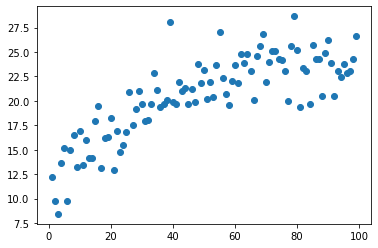

In [57]:
Y = 12*(np.sin(X/50) + 1) + np.random.normal(0, 2, X.size)
print(Y.mean(), Y.std())
plt.scatter(X, Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [grw]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


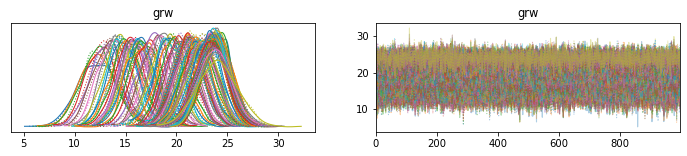

In [58]:
with pm.Model() as grw:
    grw = pm.GaussianRandomWalk('grw', mu=0, sd=1.0, shape=X.size)
    
    observed = pm.Normal('observed', mu=grw, sigma=Y.std(), observed=Y)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, 
                          return_inferencedata=True)
    summary = az.summary(trace) # used below
    az.plot_trace(trace)  


In [59]:
trace.posterior.grw.mean(axis=0).mean(axis=0)

<xarray.DataArray 'grw' (grw_dim_0: 99)>
array([12.29023821, 12.3017939 , 12.39985743, 12.77314112, 13.11447944,
       13.36885527, 13.7703244 , 14.11878545, 14.36732042, 14.65071753,
       14.80054256, 15.05708658, 15.20777733, 15.44260097, 15.73460676,
       15.95429092, 15.9336733 , 16.07936179, 16.22004054, 16.36817507,
       16.40138786, 16.6156566 , 16.83946804, 17.16549593, 17.57342122,
       17.9949875 , 18.33058781, 18.64728163, 18.95429446, 19.12705479,
       19.30306921, 19.5263637 , 19.86637195, 20.17817752, 20.34383846,
       20.4529181 , 20.64034053, 20.89670561, 21.20808084, 21.08076936,
       21.07354673, 21.15577968, 21.18701677, 21.21004511, 21.27174275,
       21.31478597, 21.44755047, 21.66821214, 21.769683  , 21.87678167,
       21.88628519, 22.03263701, 22.18313001, 22.42004107, 22.58011646,
       22.48447244, 22.4128202 , 22.40771428, 22.58236716, 22.81054008,
       22.95707313, 23.19705471, 23.30319158, 23.41418041, 23.44072242,
       23.48163465, 23.75053674, 23.94441268, 24.03834576, 24.00042058,
       24.04922126, 24.11337325, 24.07161545, 23.97937324, 23.86903839,
       23.76289737, 23.74034653, 23.86695909, 23.90808859, 23.73492942,
       23.42959894, 23.37960558, 23.31295692, 23.28100207, 23.4611308 ,
       23.49416577, 23.46083545, 23.41547394, 23.51252302, 23.54685903,
       23.46033883, 23.33453365, 23.35838517, 23.38010593, 23.47495893,
       23.57149624, 23.69840035, 23.84754445, 23.98797411])
Coordinates:
  * grw_dim_0  (grw_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 91 92 93 94 95 96 97 98

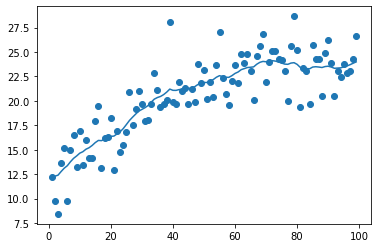

In [60]:
plt.scatter(X, Y)
plt.plot(X, trace.posterior.grw.mean(axis=0).mean(axis=0))

In [61]:
# az.summary(trace)
trace.posterior.grw.mean(axis=0).shape

(1000, 99)

In [62]:
qs = np.quantile(trace.posterior.grw.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)


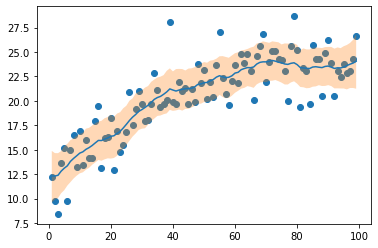

In [63]:
plt.scatter(X, Y)
plt.plot(X, qs[1])
plt.fill_between(x=X,y1=qs[0], y2=qs[2], alpha=0.3)

In [64]:
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


In [13]:
#YL = raw_df.query("partido == 'PT' ")["percentual"]
YL = 100.00 * df.LULA/df.TOTAL
OL = 100.00 * df.OUTROS/df.TOTAL
POLLSTERS = pd.Categorical(df.instituto)
print(POLLSTERS, POLLSTERS.codes)
P = len(POLLSTERS.unique())
print(P)
#print(OL)
#YL = YL.append(to_append=pd.Series([42, 36.9, 44]))
#OL = OL.append(to_append=pd.Series([45, 45, 48, 44,45, 44]))
#YL = YL.append(to_append=pd.Series([np.nan]*10))

XL = np.arange(YL.size)
# XL = df_results_weekly.data
# YL = YL.append(to_append=pd.Series([42]))
# YL[10:13]=np.nan

['Vox Populi', 'Quaest', 'Paraná Pesquisas', 'Futura', 'PoderData', ..., 'Ideia Big Data', 'PoderData', 'Futura', 'Ipespe', 'PoderData']
Length: 21
Categories (11, object): ['Atlas', 'Datafolha', 'Futura', 'Ideia Big Data', ..., 'Paraná Pesquisas', 'PoderData', 'Quaest', 'Vox Populi'] [10  9  7  2  8  0  9  3  6  2  4  1  5  8  9  5  3  8  2  5  8]
11


In [14]:
print(POLLSTERS.shape, YL.shape, OL.shape)
PRESUMED_STD = np.sqrt((50**2)/2000)
print(PRESUMED_STD)

(21,) (21,) (21,)
1.118033988749895


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [demais, lula, poll_bias, inov]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


11:31:42


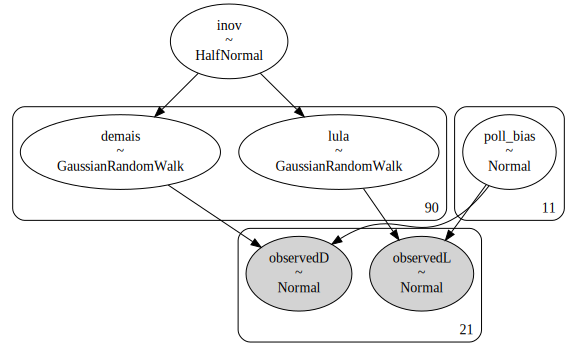

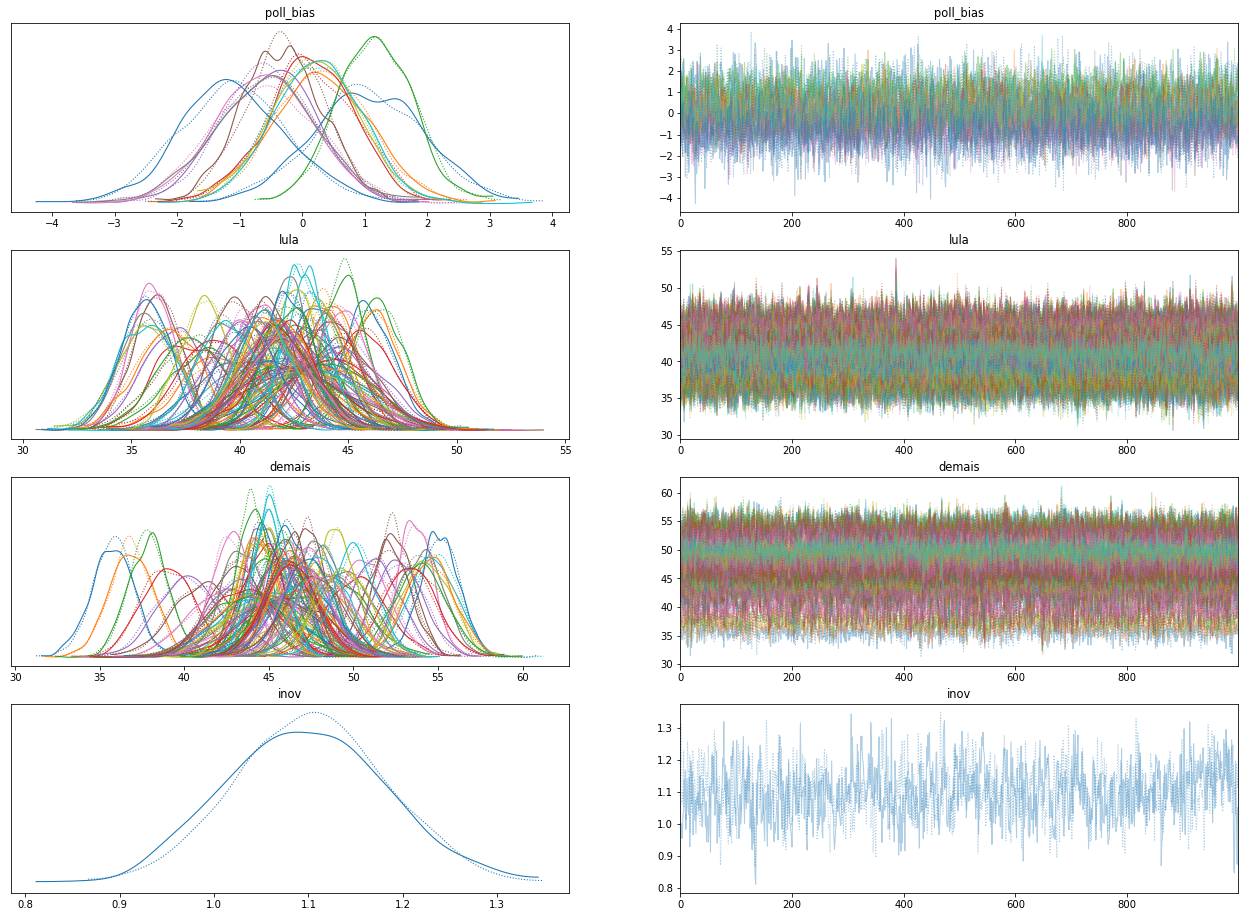

In [18]:
with pm.Model() as grw:
    
    inov = pm.HalfNormal('inov', sigma=0.15)
    
    #poll_bias = pm.Cauchy("poll_bias", alpha=0, beta=10, shape=P)
    
    #zero_sum_house_bias = pm.Deterministic('zero_sum_poll_bias', var=(poll_bias - poll_bias.mean()))
    poll_bias = pm.Normal("poll_bias", 0, 1.00, shape=P)
    
    grw_lula = pm.GaussianRandomWalk('lula', mu=0, sd=inov, shape=n_days)
    
    grw_demais = pm.GaussianRandomWalk('demais', mu=0, sd=inov, shape=n_days)
    
    #sigma = pm.HalfCauchy("sigma", beta=10)
    

    pm.Normal('observedL', mu=grw_lula[poll_day] + poll_bias[POLLSTERS.codes], sigma=PRESUMED_STD**2, observed=YL)
    pm.Normal('observedD', mu=grw_demais[poll_day] + poll_bias[POLLSTERS.codes], sigma=PRESUMED_STD**2, observed=OL)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, return_inferencedata=True)

    summary = az.summary(trace) # used below
    az.plot_trace(trace, figsize=(22,16))  
print(datetime.now().strftime("%H:%M:%S"))
pm.model_to_graphviz(grw)

In [19]:
print(trace.posterior.lula.mean(axis=0).shape)
print(trace.posterior.demais.mean(axis=0).shape)

(1000, 90)
(1000, 90)


In [20]:
poll_day.values

array([ 0,  2, 15, 16, 20, 25, 31, 35, 37, 39, 39, 42, 42, 47, 66, 69, 70,
       75, 78, 82, 89])

In [21]:
datas = []
print(n_days)
for d in range(n_days):
    datas.append((pd.to_datetime(df.data_pesquisa).min() + pd.Timedelta(days=d)).strftime("%Y-%m-%d"))

90


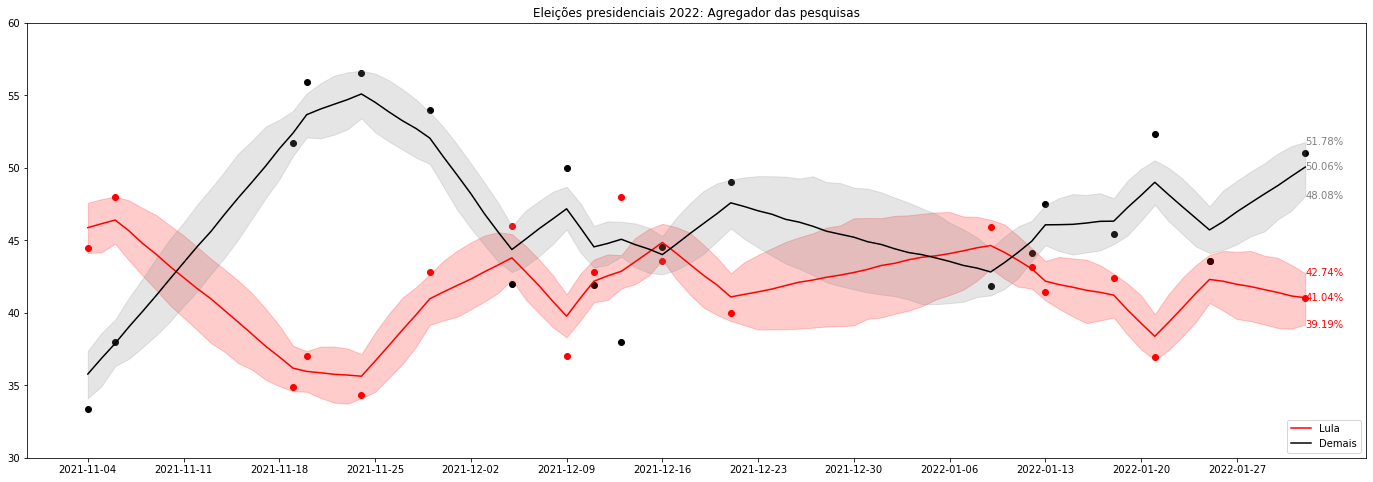

In [22]:
qsL = np.quantile(trace.posterior.lula.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
qsD = np.quantile(trace.posterior.demais.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
# print(qs[0].shape)
pdv = poll_day.values
# df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0][pdv], 'M':qs[1][pdv], 'UB':qs[2][pdv]})
# print(df_rand_walk)
# table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
# table_rw.columns = table_rw.columns.to_flat_index()
# print(table_rw)

plt.figure(figsize=(24,8))
plt.ylim(30, 60)
L = np.zeros(n_days) * np.nan
O = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.plot(datas, qsL[1], color='red', label="Lula")
plt.fill_between(x=datas, y1=qsL[0], y2=qsL[2], alpha=0.2, color='red')
plt.text(datas[-1], qsL[0][-1]-.2, f'{qsL[0][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');

plt.plot(datas, qsD[1], color='black', label="Demais");
plt.fill_between(x=datas, y1=qsD[0], y2=qsD[2], alpha=0.2, color='gray');
plt.text(datas[-1], qsD[0][-1]-.2, f'{qsD[0][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[1][-1]-.2, f'{qsD[1][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[2][-1]-.2, f'{qsD[2][-1]:.2f}%', color='gray');
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='lower right');

In [23]:
df_results_weekly['LULA'] = df.LULA.values
df_results_weekly['DEMAIS'] = df.OUTROS.values
df_results_weekly['TOTAL'] = df.TOTAL.values

df_results_weekly

NameError: name 'df_results_weekly' is not defined

## MULTIVARIATE

In [24]:
PRESUMED_STD = 1.2
cov = np.cov(np.array([YL, OL]))
print(cov)
print(np.array([[1.7]]))

[[ 17.95233128 -22.63980247]
 [-22.63980247  40.86040771]]
[[1.7]]


In [33]:
import theano.tensor as tt
from datetime import datetime
with pm.Model() as grw:
    
    inov = pm.HalfNormal('inov', sigma=0.15)
    
    # poll_bias = pm.Cauchy("poll_bias", alpha=0, beta=10, shape=P)
    
    # zero_sum_house_bias = pm.Deterministic('zero_sum_poll_bias', var=(poll_bias - poll_bias.mean()))
    # poll_bias = pm.Normal("poll_bias", 0, 1.00, shape=P)
    sd_dist = pm.Exponential.dist(1.0)
    chol, _, _ = pm.LKJCholeskyCov('chol_cov', n=2, eta=4, sd_dist=sd_dist, compute_corr=True)
    
    grw_lula = pm.GaussianRandomWalk('lula', mu=0, sd=inov, shape=n_days)
    
    grw_demais = pm.GaussianRandomWalk('demais', mu=0, sd=inov, shape=n_days)
    cov = tt.dot(chol, chol.T)
    
    pm.MvStudentT('observed', nu=len(YL)-1, mu=tt.stack([grw_lula[poll_day], grw_demais[poll_day]], axis=1), cov=cov, observed=np.array([YL, OL]).T)
    
    trace = pm.sample(1000, tune=1000, progressbar=True, return_inferencedata=True)

    summary = az.summary(trace) # used below
    az.plot_trace(trace, figsize=(22,16))  
print(datetime.now().strftime("%H:%M:%S"))
pm.model_to_graphviz(grw)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [demais, lula, chol_cov, inov]


ValueError: Not enough samples to build a trace.

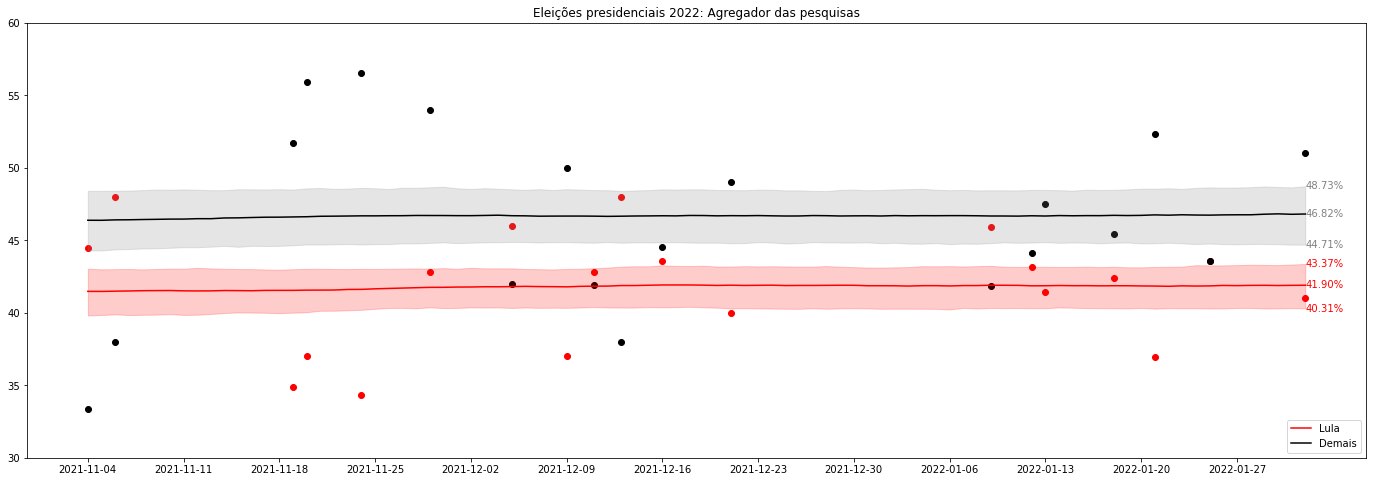

In [ ]:
qsL = np.quantile(trace.posterior.lula.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
qsD = np.quantile(trace.posterior.demais.mean(axis=0), q=[0.025, 0.5, 0.975], axis=0)
# print(qs[0].shape)
pdv = poll_day.values
# df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0][pdv], 'M':qs[1][pdv], 'UB':qs[2][pdv]})
# print(df_rand_walk)
# table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
# table_rw.columns = table_rw.columns.to_flat_index()
# print(table_rw)

plt.figure(figsize=(24,8))
plt.ylim(30, 60)
L = np.zeros(n_days) * np.nan
O = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.plot(datas, qsL[1], color='red', label="Lula")
plt.fill_between(x=datas, y1=qsL[0], y2=qsL[2], alpha=0.2, color='red')
plt.text(datas[-1], qsL[0][-1]-.2, f'{qsL[0][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');

plt.plot(datas, qsD[1], color='black', label="Demais");
plt.fill_between(x=datas, y1=qsD[0], y2=qsD[2], alpha=0.2, color='gray');
plt.text(datas[-1], qsD[0][-1]-.2, f'{qsD[0][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[1][-1]-.2, f'{qsD[1][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[2][-1]-.2, f'{qsD[2][-1]:.2f}%', color='gray');
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='lower right');

In [ ]:
qsL = np.quantile(trace.posterior.grw.mean(axis=0)[:,:,0], q=[0.025, 0.5, 0.975], axis=0)
qsD = np.quantile(trace.posterior.grw.mean(axis=0)[:,:,1], q=[0.025, 0.5, 0.975], axis=0)
# print(qs[0].shape)
pdv = poll_day.values
# df_rand_walk = pd.DataFrame({'data_pesquisa': df.data_pesquisa, 'LULA': 100.0 * df.LULA/df.TOTAL, 'LB': qs[0][pdv], 'M':qs[1][pdv], 'UB':qs[2][pdv]})
# print(df_rand_walk)
# table_rw = df_rand_walk.groupby('data_pesquisa').mean().reset_index(col_level=1).copy()
# table_rw.columns = table_rw.columns.to_flat_index()
# print(table_rw)

plt.figure(figsize=(24,8))
plt.ylim(30, 60)
L = np.zeros(n_days) * np.nan
O = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.plot(datas, qsL[1], color='red', label="Lula")
plt.fill_between(x=datas, y1=qsL[0], y2=qsL[2], alpha=0.2, color='red')
plt.text(datas[-1], qsL[0][-1]-.2, f'{qsL[0][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');

plt.plot(datas, qsD[1], color='black', label="Demais");
plt.fill_between(x=datas, y1=qsD[0], y2=qsD[2], alpha=0.2, color='gray');
plt.text(datas[-1], qsD[0][-1]-.2, f'{qsD[0][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[1][-1]-.2, f'{qsD[1][-1]:.2f}%', color='gray');
plt.text(datas[-1], qsD[2][-1]-.2, f'{qsD[2][-1]:.2f}%', color='gray');
plt.xticks([d for i,d in enumerate(datas) if i % 7 ==0]);
plt.legend(loc='lower right');

AttributeError: 'Dataset' object has no attribute 'grw'

## Multinomial distribution

In [ ]:
df

,data_pesquisa,instituto,LULA,NULO,OUTROS,TOTAL,mes
0,2021-11-04,Vox Populi,880.000,440.000,660.000,1980.0,2021_11
1,2021-11-06,Quaest,990.240,288.820,783.940,2063.0,2021_11
2,2021-11-19,Paraná Pesquisas,704.980,270.680,1044.340,2020.0,2021_11
3,2021-11-20,Futura,740.000,142.000,1118.000,2000.0,2021_11
4,2021-11-24,PoderData,850.000,225.000,1400.000,2475.0,2021_11
5,2021-11-29,Atlas,1883.628,140.832,2376.540,4401.0,2021_11
6,2021-12-05,Quaest,937.020,244.440,855.540,2037.0,2021_12
7,2021-12-09,Ideia Big Data,444.000,156.000,600.000,1200.0,2021_12
8,2021-12-11,MDA,856.856,306.306,838.838,2002.0,2021_12
9,2021-12-13,Futura,758.000,170.000,1072.000,2000.0,2021_12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [concentration, nulo, demais, lula]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 155 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6944192496702897, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


17:37:21


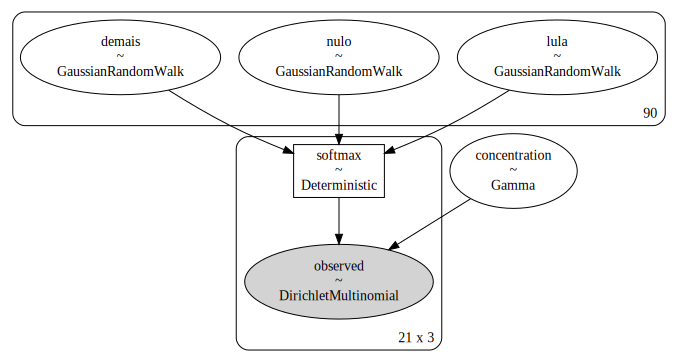

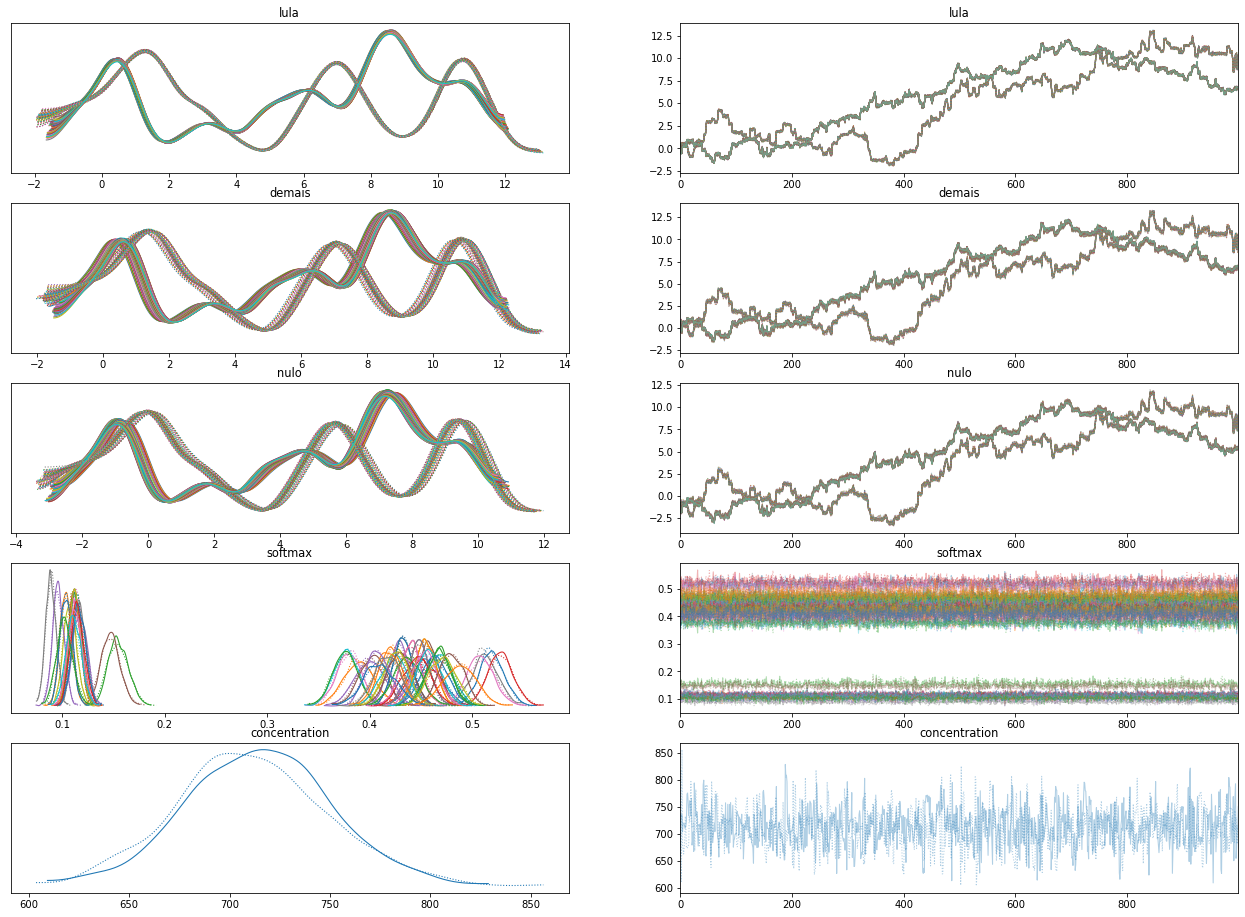

In [200]:
import theano.tensor as tt
from datetime import datetime

LULA = df.LULA.astype("int32")
OUTROS = df.OUTROS.astype("int32")
NULO = df.NULO.astype("int32")
TOTAL = LULA + OUTROS + NULO

# inov = 0.025
inov = 0.025

with pm.Model() as grw:
    
    # inov = pm.HalfNormal('inov', sigma=0.15)
    
    # alpha = pm.Normal("alpha", shape=3)
    # baseline = pm.Normal("baseline", shape=(poll_day.shape[0], 3))
    
    grw_lula = pm.GaussianRandomWalk('lula', mu=0, sd=inov, shape=n_days)
    
    grw_demais = pm.GaussianRandomWalk('demais', mu=0, sd=inov, shape=n_days)
    
    grw_nulo  = pm.GaussianRandomWalk('nulo', mu=0, sd=inov, shape=n_days)
    # grw  = pm.GaussianRandomWalk('grw', mu=0, sd=inov, shape=(n_days, 3))
    

    prob = pm.Deterministic("softmax", tt.nnet.softmax(tt.stack([grw_lula[poll_day], grw_demais[poll_day], grw_nulo[poll_day]], axis=1)))
    # prior = tt.nnet.softmax(grw[poll_day])
    
    # conc = pm.Gamma("concentration",
    #                 alpha=(1000.0 * prob),
    #                 beta=(1.0 * np.ones(3)), shape=(poll_day.shape[0], 3)
    #         )
    conc  = pm.Gamma("concentration", alpha=400, beta=0.5)
    
    pm.DirichletMultinomial('observed', n=TOTAL, a=prob * conc, observed=np.array([LULA.values, OUTROS.values, NULO.values]).T, shape=(poll_day.shape[0], 3))
    
    trace = pm.sample(5000, tune=10000, progressbar=True, return_inferencedata=True) # , chains=4, cores=2)

    summary = az.summary(trace) # used below
    az.plot_trace(trace, figsize=(22,16))  
print(datetime.now().strftime("%H:%M:%S"))
pm.model_to_graphviz(grw)

In [201]:
# summary
#print(np.array([LULA.values, OUTROS.values, NULO.values]).T)
# v = tt.nnet.softmax(tt.stack([LULA.astype("float32").values, OUTROS.astype("float32").values, NULO.astype("float32").values], axis=1)) + np.array([0.1,0.1,0.1])
# v.eval()
#trace.posterior.baseline.mean(axis=0).mean(axis=0)
# L.shape

In [202]:
# np.array([LULA.values, OUTROS.values, NULO.values]).shape
n_days

90

In [203]:
# baseline = trace.posterior.baseline.mean(axis=0)
L = trace.posterior.lula.mean(axis=0)
D = trace.posterior.demais.mean(axis=0)
N = trace.posterior.nulo.mean(axis=0)
#IL = 
#print(baseline.shape)
TT = tt.stack([L,D,N], axis=1).eval()
print(TT.shape)
probs = []
#(baseline + tt.stack([L,D,N], axis=1).eval()[:,:,0]).shape
for i in range(n_days):
    probs.append(tt.nnet.softmax( TT[:,:,i]).eval())
probs = np.array(probs)
probs.shape

(1000, 3, 90)


(90, 1000, 3)

In [204]:
probs[:,:,:].mean(axis=1)

array([[0.45574375, 0.38980161, 0.15445464],
       [0.45412186, 0.39508436, 0.15079378],
       [0.4526466 , 0.40021868, 0.14713472],
       [0.44741633, 0.40869794, 0.14388573],
       [0.44196069, 0.41736383, 0.14067548],
       [0.43656348, 0.42607752, 0.137359  ],
       [0.43137565, 0.43463333, 0.13399103],
       [0.42592473, 0.44312389, 0.13095138],
       [0.42018246, 0.45191097, 0.12790657],
       [0.41477093, 0.46025469, 0.12497439],
       [0.4090486 , 0.46903321, 0.12191819],
       [0.40323774, 0.47778094, 0.11898133],
       [0.39750272, 0.48632276, 0.11617453],
       [0.39179777, 0.49503923, 0.113163  ],
       [0.38611115, 0.50352403, 0.11036483],
       [0.380094  , 0.51231153, 0.10759446],
       [0.37726166, 0.51905286, 0.10368548],
       [0.37707222, 0.52124312, 0.10168466],
       [0.37680299, 0.52334958, 0.09984743],
       [0.37680263, 0.52526447, 0.0979329 ],
       [0.37648204, 0.52745505, 0.09606291],
       [0.38134779, 0.52401759, 0.09463463],
       [0.

(5, 90, 3)


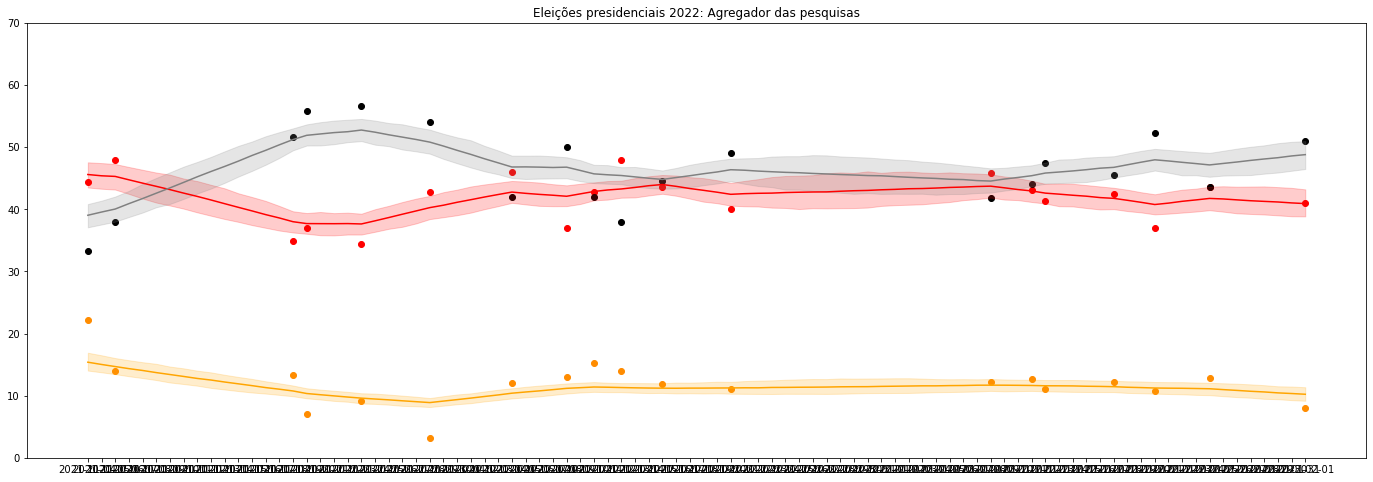

In [205]:
qs = np.quantile(probs[:,:,:], q=[0.025, 0.1, 0.5, 0.9, 0.975], axis=1)
print(qs.shape)
plt.figure(figsize=(24,8))
plt.ylim(0, 70)
L = np.zeros(n_days) * np.nan
O = L.copy()
N = L.copy()
L[poll_day.values] = 100.0 * df.LULA/df.TOTAL
O[poll_day.values] = 100.0 * df.OUTROS/df.TOTAL
N[poll_day.values] = 100.0 * df.NULO/df.TOTAL
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.scatter(datas, L, color='red')
plt.scatter(datas, O, color='black')
plt.scatter(datas, N, color='darkorange')
plt.plot(datas, qs[2,:,0]*100, color='red', label="Lula")
plt.plot(datas, qs[2,:,1]*100, color='gray', label="Demais")
plt.plot(datas, qs[2,:,2]*100, color='orange', label="Nulo")
plt.fill_between(x=datas, y1=qs[0,:,0]*100., y2=qs[4,:,0]*100., alpha=0.2, color='red')
plt.fill_between(x=datas, y1=qs[0,:,1]*100., y2=qs[4,:,1]*100., alpha=0.2, color='gray')
plt.fill_between(x=datas, y1=qs[0,:,2]*100., y2=qs[4,:,2]*100., alpha=0.2, color='orange')
#plt.text(datas[-1], qs[0][-1]-.2, f'{qs[0,:,0]:.2f}%', color='red');
#plt.text(datas[-1], qsL[1][-1]-.2, f'{qsL[1][-1]:.2f}%', color='red');
#plt.text(datas[-1], qsL[2][-1]-.2, f'{qsL[2][-1]:.2f}%', color='red');


In [206]:
qs[2,:,0]*100

array([45.59856866, 45.39304113, 45.29386382, 44.74958496, 44.21259602,
       43.69749887, 43.16935495, 42.60799368, 42.074573  , 41.50147957,
       40.90555171, 40.31931538, 39.74344142, 39.14490083, 38.60554421,
       38.00212873, 37.70022191, 37.68959622, 37.6825198 , 37.70030907,
       37.64021358, 38.14674179, 38.67180238, 39.2098632 , 39.73694966,
       40.27043896, 40.65846369, 41.13074365, 41.54520103, 41.97683815,
       42.3810937 , 42.77337956, 42.56946168, 42.40227662, 42.26468336,
       42.09784225, 42.48311606, 42.86935551, 43.1099136 , 43.27268858,
       43.51499362, 43.79562134, 43.99081022, 43.6970859 , 43.34726839,
       43.05630759, 42.75061656, 42.41186643, 42.51597132, 42.57525807,
       42.60597578, 42.69860447, 42.74777392, 42.78474555, 42.80302476,
       42.90692294, 42.98900496, 43.03999703, 43.13925022, 43.20728039,
       43.3082318 , 43.34162891, 43.41846992, 43.51714474, 43.58105495,
       43.6691312 , 43.72395608, 43.46101932, 43.17777407, 42.95

## Weekly results ploted daily

In [207]:
dfrw = df_results_weekly.groupby('data').mean().reset_index(col_level=1).copy()
dfrw.columns = dfrw.columns.to_flat_index()
# print(dfrw)
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))

plt.scatter(df.data_pesquisa, df.LULA/df.TOTAL, color='red')
plt.scatter(df.data_pesquisa, df["OUTROS"]/df["TOTAL"], color='gray')
plt.plot(dfrw.data, dfrw.LulaM, color='red', label="Lula")
plt.fill_between(x=dfrw.data, y1=dfrw.LulaLB, y2=dfrw.LulaUB, alpha=0.2, color='red')
plt.plot(dfrw.data, dfrw.DemaisM, color='gray', label="Demais")
plt.fill_between(x=dfrw.data, y1=dfrw.DemaisLB, y2=dfrw.DemaisUB, alpha=0.2, color='gray')

plt.text(dfrw.data.values[-1], dfrw.LulaUB.values[-1]-.001, f'{dfrw.LulaUB.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaM.values[-1]-.001, f'{dfrw.LulaM.values[-1] * 100:.2f}%', color='red')
plt.text(dfrw.data.values[-1], dfrw.LulaLB.values[-1]-.001, f'{dfrw.LulaLB.values[-1] * 100:.2f}%', color='red')

plt.text(dfrw.data.values[-1], dfrw.DemaisUB.values[-1]-.001, f'{dfrw.DemaisUB.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisM.values[-1]-.001, f'{dfrw.DemaisM.values[-1] * 100:.2f}%', color='gray')
plt.text(dfrw.data.values[-1], dfrw.DemaisLB.values[-1]-.001, f'{dfrw.DemaisLB.values[-1] * 100:.2f}%', color='gray')
plt.legend(loc='lower right')
plt.xticks([d for i,d in enumerate(dfrw.data.values) if i % 2 ==0]);
plt.show()

NameError: name 'df_results_weekly' is not defined

In [ ]:

blabla

NameError: name 'blabla' is not defined

### Machine Learning

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
to_dt = lambda x: pd.to_datetime(x)
day_zero = to_dt(df.data_pesquisa).min()
n_days = int((to_dt(df.data_pesquisa).max() - day_zero) / pd.Timedelta(days=1)) + 1
poll_day = ((to_dt(df.data_pesquisa) - day_zero) / pd.Timedelta(days=1)).astype(int)

In [ ]:
print(f'{day_zero=}')
print(f'{n_days=}')
print(f'{poll_day.values=}')

day_zero=Timestamp('2021-11-04 00:00:00')
n_days=90
poll_day.values=array([ 0,  2, 15, 16, 20, 25, 31, 35, 37, 39, 39, 42, 42, 47, 66, 69, 70,
       75, 78, 82, 89])


In [ ]:
svr = SVR(kernel='rbf', C=50, gamma=1e-3, epsilon=0.1)
Y = 100* df.LULA/df.TOTAL
print(poll_day.shape, Y.shape)

(21,) (21,)


In [ ]:
svr.fit(poll_day.values.reshape(-1,1), Y, sample_weight=df.TOTAL/2000.0)

SVR(C=50, gamma=0.001)

In [ ]:
pred_lula = svr.predict(np.arange(0,85).reshape(-1,1))

In [ ]:
pred_lula

array([44.34454373, 43.63773655, 42.94545908, 42.27342395, 41.6271523 ,
       41.01190004, 40.43258711, 39.89373102, 39.3993859 , 38.95308824,
       38.55781028, 38.21592187, 37.92916172, 37.69861843, 37.52472164,
       37.40724371, 37.34531152, 37.33742857, 37.38150654, 37.47490601,
       37.61448535, 37.79665681, 38.01744884, 38.27257327, 38.55749614,
       38.86751075, 39.19781161, 39.5435678 , 39.89999452, 40.26242142,
       40.62635656, 40.98754491, 41.34202049, 41.68615126, 42.01667627,
       42.33073454, 42.62588549, 42.90012081, 43.15186792, 43.37998533,
       43.58375035, 43.76283979, 43.9173043 , 44.04753739, 44.15423978,
       44.23838037, 44.3011546 , 44.34394144, 44.36825985, 44.37572575,
       44.36801052, 44.3468016 , 44.31376624, 44.27051874, 44.21859189,
       44.1594129 , 44.094284  , 44.02436805, 43.95067885, 43.87407638,
       43.79526637, 43.71480426, 43.63310277, 43.55044291, 43.46698772,
       43.38279826, 43.29785124, 43.21205767, 43.12528204, 43.03

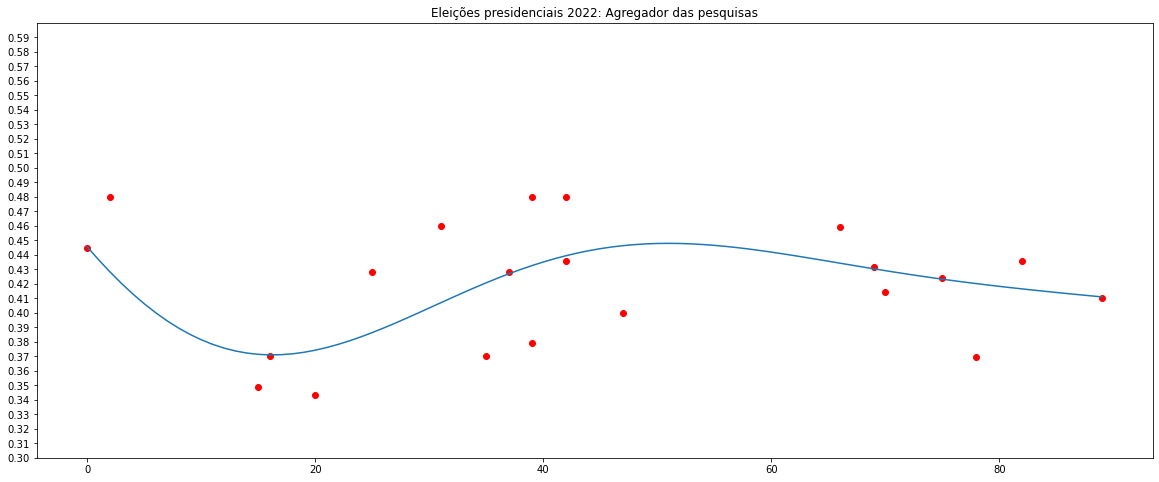

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))
plt.scatter(poll_day, df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(pred_lula.shape[0]), pred_lula/100.);

In [ ]:
from sklearn.model_selection import GridSearchCV
svr = SVR()
parameters = {'C': np.arange(500, 2000, 50), 'gamma': np.arange(1e-05, 1.1e-3, 1e-5)}

In [ ]:
clf = GridSearchCV(svr, parameters, scoring='neg_mean_squared_error', cv=poll_day.values.size//1, verbose=1)
clf.fit(poll_day.values.reshape(-1,1), Y, sample_weight=np.sqrt(df.TOTAL/df.TOTAL.min()))

Fitting 21 folds for each of 3270 candidates, totalling 68670 fits


GridSearchCV(cv=21, estimator=SVR(),
             param_grid={'C': array([ 500,  550,  600,  650,  700,  750,  800,  850,  900,  950, 1000,
       1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
       1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950]),
                         'gamma': array([1.00e-05, 2.00e-05, 3.00e-05, 4.00e-05, 5.00e-05, 6.00e-05,
       7.00e-05, 8.00e-05, 9.00e-05, 1.00e-04, 1.10e-04, 1.20e-04,
       1.30e-04, 1.40e-04, 1.50e-04,...
       7.30e-04, 7.40e-04, 7.50e-04, 7.60e-04, 7.70e-04, 7.80e-04,
       7.90e-04, 8.00e-04, 8.10e-04, 8.20e-04, 8.30e-04, 8.40e-04,
       8.50e-04, 8.60e-04, 8.70e-04, 8.80e-04, 8.90e-04, 9.00e-04,
       9.10e-04, 9.20e-04, 9.30e-04, 9.40e-04, 9.50e-04, 9.60e-04,
       9.70e-04, 9.80e-04, 9.90e-04, 1.00e-03, 1.01e-03, 1.02e-03,
       1.03e-03, 1.04e-03, 1.05e-03, 1.06e-03, 1.07e-03, 1.08e-03,
       1.09e-03])},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
clf.best_params_

{'C': 550, 'gamma': 0.00048000000000000007}

In [ ]:
np.arange(1e-3, 1e-1, 5e-3)

array([0.001, 0.006, 0.011, 0.016, 0.021, 0.026, 0.031, 0.036, 0.041,
       0.046, 0.051, 0.056, 0.061, 0.066, 0.071, 0.076, 0.081, 0.086,
       0.091, 0.096])

In [ ]:
pred_lula = clf.best_estimator_.predict(np.arange(0,n_days).reshape(-1,1))

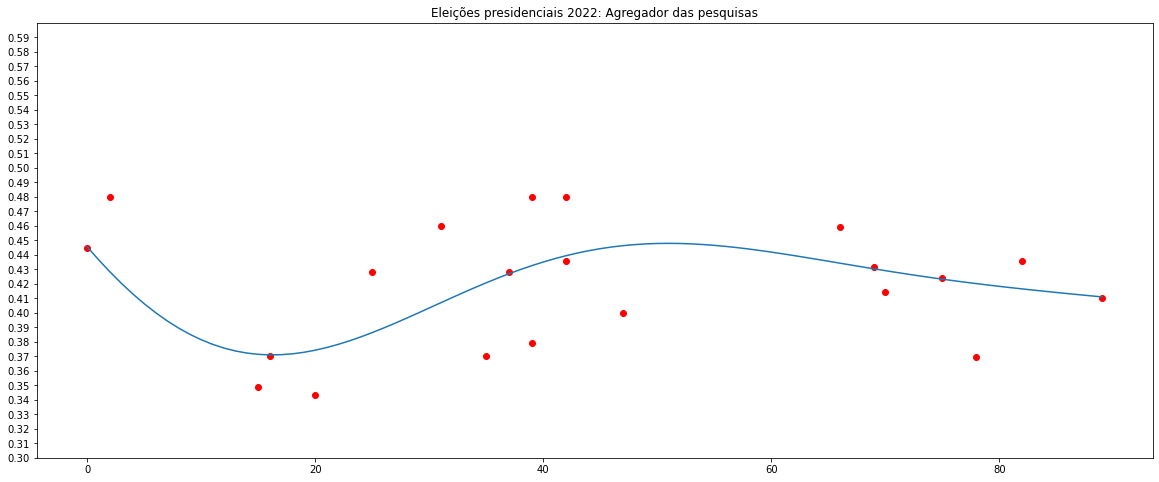

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(0.30, 0.60)
plt.yticks(np.arange(0.30, 0.60, 0.01))
plt.scatter(poll_day, df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,n_days), pred_lula/100.)

In [ ]:
res = []
svr = SVR(C=1600, gamma=7.000000000000001e-05)
x_pred = np.arange(0, n_days)
a = np.arange(0, poll_day.values.size)
sw = df.TOTAL/df.TOTAL.min()
for _ in range(10_000):
    idx = np.random.choice(a, size=poll_day.values.size)
    svr.fit(poll_day.iloc[idx].values.reshape(-1,1), Y.iloc[idx].values, sample_weight=sw.iloc[idx].values)
    res.append(svr.predict(x_pred.reshape(-1,1)))
res = np.array(res)
print(res.shape)

(10000, 90)


In [ ]:
qs = np.quantile(res, q=[0.025, 0.2, 0.5, 0.8, 0.975], axis=0)
qs.shape

(5, 90)

Text(89, 30.248883537318253, '30.50%')

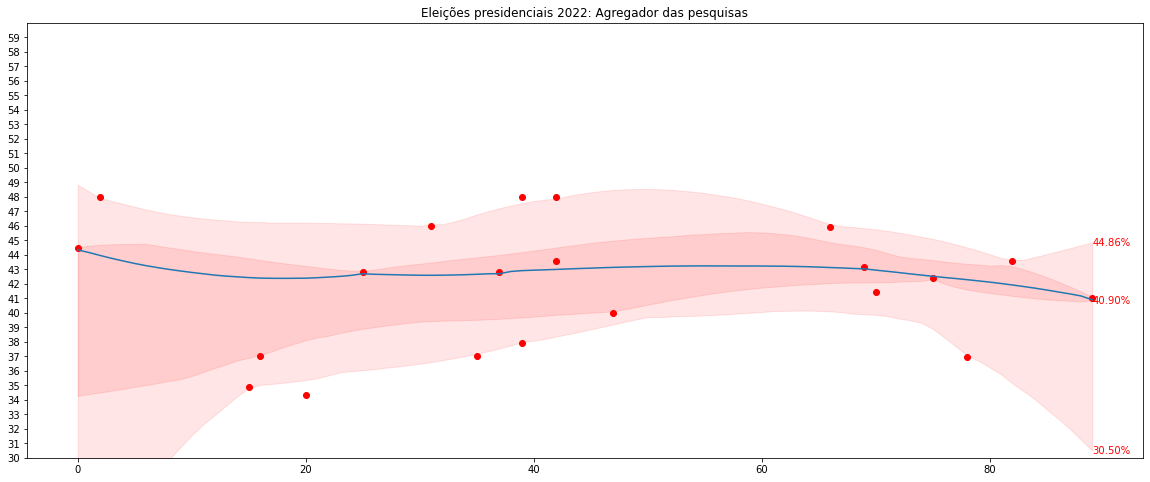

In [ ]:
plt.figure(figsize=(20,8))
plt.title("Eleições presidenciais 2022: Agregador das pesquisas")
plt.ylim(30, 60)
plt.yticks(np.arange(30, 60, 1))
plt.scatter(poll_day, 100*df.LULA/df.TOTAL, color='red')
plt.plot(np.arange(0,n_days), qs[2])
plt.fill_between(x=np.arange(0,n_days), y1=qs[0], y2=qs[4], alpha=0.1, color='red')
plt.fill_between(x=np.arange(0,n_days), y1=qs[1], y2=qs[3], alpha=0.1, color='red')
plt.text(n_days-1, qs[4][-1]-.25, f'{qs[4][-1]:.2f}%', color='red')
plt.text(n_days-1, qs[2][-1]-.25, f'{qs[2][-1]:.2f}%', color='red')
plt.text(n_days-1, qs[0][-1]-.25, f'{qs[0][-1]:.2f}%', color='red')


In [ ]:
from sklearn.neural_network import MLPClassifier

res = []
rf = RandomForestClassifier(n_estimators=100)
x_pred = np.arange(0, n_days)
a = np.arange(0, poll_day.values.size)
sw = np.sqrt(df.TOTAL/df.TOTAL.min())
Y = np.array([df.LULA/df.TOTAL, df.OUTROS/df.TOTAL, df.NULO/df.TOTAL]).T
print(Y.shape)
for _ in range(10_000):
    idx = np.random.choice(a, size=poll_day.values.size)
    rf.fit(poll_day.iloc[idx].values.reshape(-1,1), Y[idx], sample_weight=sw.iloc[idx].values)
    res.append(rf.predict(x_pred.reshape(-1,1)))
res = np.array(res)
print(res.shape)

NameError: name 'RandomForestClassifier' is not defined

## Multinomial Logistic Regression with custom loss function

In [ ]:
def linear(x, betas):
    return np.dot(x, np.array(betas).reshape(x.shape[1], -1))

def multinomial(z):
    return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)

def costJ(X, y, theta, C, weight=None):
    m = y.shape[0]
    if weight is None:
        weight = np.repeat(1.0, m).reshape(m,1)
    else:
        weight = weight.reshape(m,1)
    res = np.abs(y - multinomial(linear(X, theta)))
    regul = np.sum(weight * C * np.sum(theta**2))
    return 1./m * (np.sum((10*res)**2) + regul)
    #return 1./m * np.sum(-np.log(1. - res + 1e-6) + regul)
    # return np.sum(-np.log(1.0 - res + 1e-6))
    

In [ ]:
x = np.hstack([np.ones((10,1)), np.ones((10,1)) * np.arange(10).reshape(10,-1)])
betas = np.random.randn(2,3)
x, betas

In [ ]:
linear(x, betas)

In [ ]:
multinomial(linear(x,betas))

In [ ]:
pred = multinomial(linear(x, betas))
costJ(x, pred+0.05, betas, 1.0, np.arange(1,11))

In [ ]:
truth = np.random.dirichlet(alpha=[440, 120, 440], size=2)
truth = truth.mean(axis=0) - (np.arange(1,11).reshape(10,1)*0.001) + np.random.randn(10,3)*0.01
truth = truth/truth.sum(axis=1).reshape(-1,1)
print(truth)

In [ ]:

opt = lambda bs: costJ(x, truth, bs, 0.05, np.arange(10,0, -1)) 
 

In [ ]:
import scipy as sp
found = False
res = sp.optimize.minimize(opt, np.random.randn(6), method='BFGS', options={'gtol': 1e-6})
print(res.success)


In [ ]:
computed_betas = res.x

In [ ]:
multinomial(linear(x, computed_betas))

In [ ]:
truth